In [1]:
import pandas as pd
import glob
import os
from pathlib import Path
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
import re
from thefuzz import fuzz
from fuzzywuzzy import process
from collections import Counter
sns.set_style('darkgrid')
import geopandas
import geoplot as gplt
import geoplot.crs as gcrs
import json
import requests
%matplotlib inline

In [2]:
#Leemos los datasets
path = r'D:\datascience\siniestros-viales\datos\siniestros' # Acá ponemos la dirección de la carpeta donde tenemos nuestros csv
all_files = Path(path).glob('*.csv')

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

data = pd.concat(li, axis=0, ignore_index=True)



In [3]:
#Examinamos el data set
print('El siguiente set de datos contiene '+ str(data.shape[0]) + ' registros y '+ str(data.shape[1]) + ' columnas')
data.head(3)

El siguiente set de datos contiene 108098 registros y 42 columnas


,anio_acci,nro_acci,fecha,desc_dia,fecha_aprox,hora_aprox,desc_ruta,km,cant_participantes,desc_participante,...,desc_estado_visibilidad,desc_luminosidad,desc_estado_clima,desc_tipo_colision,desc_tipo_atropello,desc_tipo_hecho,desc_pres_calzada,desc_senializacion,desc_separacion_via,desc_restriccion
0,2012,1,04/01/2012,Miercoles,0.0,13:30:00,NaN,0.0,2,"Moto/Ciclomotor,Pickup/Utilitario",...,Buena,Diurna,Buen Tiempo,Frontal,S/D,Colisión,S/D,S/D,Ninguna,S/D
1,2012,2,05/01/2012,Jueves,0.0,12:30:00,NaN,0.0,2,"Moto/Ciclomotor,Pickup/Utilitario",...,Buena,Diurna,Buen Tiempo,Frontal,S/D,Colisión,S/D,S/D,S/D,S/D
2,2012,3,05/01/2012,Jueves,0.0,20:15:00,NaN,0.0,2,"Moto/Ciclomotor,Pickup/Utilitario",...,Buena,Atardecer,Buen Tiempo,Frontal,S/D,Colisión,S/D,S/D,S/D,S/D


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108098 entries, 0 to 108097
Data columns (total 42 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   anio_acci                108098 non-null  int64  
 1   nro_acci                 108098 non-null  int64  
 2   fecha                    108098 non-null  object 
 3   desc_dia                 108098 non-null  object 
 4   fecha_aprox              86854 non-null   float64
 5   hora_aprox               97769 non-null   object 
 6   desc_ruta                17562 non-null   object 
 7   km                       108098 non-null  float64
 8   cant_participantes       108098 non-null  int64  
 9   desc_participante        107794 non-null  object 
 10  calle_avenida_km         107505 non-null  object 
 11  total                    108098 non-null  int64  
 12  heridos_leves            108098 non-null  int64  
 13  heridos_graves           108098 non-null  int64  
 14  heri

In [5]:
data.isna().sum()

anio_acci                      0
nro_acci                       0
fecha                          0
desc_dia                       0
fecha_aprox                21244
hora_aprox                 10329
desc_ruta                  90536
km                             0
cant_participantes             0
desc_participante            304
calle_avenida_km             593
total                          0
heridos_leves                  0
heridos_graves                 0
heridos_gravisimos             0
ilesos                         0
fallecidos                     0
sin_datos                      0
posicion_XY                72162
desc_tipo_via                  0
desc_ruta_ori              90536
desc_loc                       0
desc_dpto                      0
desc_tipo_calzada              0
desc_tipo_banquina             0
desc_unidad_regional           0
desc_lugar_calzada             0
desc_zona                      0
desc_prioridad                 0
desc_estado_semaforo           0
desc_lugar

In [6]:
#Subseteamos el data set en datos geograficos para futuros análisis

geo_cols = ['posicion_XY','desc_loc','desc_tipo_via','ilesos','heridos_leves','heridos_graves','heridos_gravisimos','fallecidos']
geodata = data[geo_cols]

# DATA CLEANING

In [7]:
#Creamos una lista con las columnas que no vamos a usar eneste análisis
columnas_innecesarias = ['anio_acci','nro_acci','desc_dia','desc_ruta','km','calle_avenida_km',
                         'km','total','sin_datos','desc_ruta_ori',
                         'desc_tipo_banquina','desc_unidad_regional','desc_lugar_calzada','desc_tipo_calzada','desc_prioridad','posicion_XY',
                         'desc_estado_semaforo','desc_tipo_colision','desc_pres_calzada',
                         'desc_senializacion','desc_restriccion','fecha_aprox','desc_separacion_via','desc_estado_via','desc_luminosidad','desc_tipo_atropello','desc_estado_visibilidad']

data.drop(columnas_innecesarias, axis='columns', inplace=True) #Eliminamos las columnas

In [8]:
#Examinamos el data set
print('El nuevo set de datos contiene '+ str(data.shape[0]) + ' registros y '+ str(data.shape[1]) + ' columnas')
data.head(3)

El nuevo set de datos contiene 108098 registros y 16 columnas


,fecha,hora_aprox,cant_participantes,desc_participante,heridos_leves,heridos_graves,heridos_gravisimos,ilesos,fallecidos,desc_tipo_via,desc_loc,desc_dpto,desc_zona,desc_lugar_via,desc_estado_clima,desc_tipo_hecho
0,04/01/2012,13:30:00,2,"Moto/Ciclomotor,Pickup/Utilitario",1,0,0,1,0,Calle,SANTA FE,La Capital,Urbana,Intersección,Buen Tiempo,Colisión
1,05/01/2012,12:30:00,2,"Moto/Ciclomotor,Pickup/Utilitario",1,0,0,1,0,Calle,SANTA FE,La Capital,Urbana,Intersección,Buen Tiempo,Colisión
2,05/01/2012,20:15:00,2,"Moto/Ciclomotor,Pickup/Utilitario",1,0,0,1,0,Calle,SANTA FE,La Capital,Urbana,Intersección,Buen Tiempo,Colisión


In [9]:
#Vamos a reemplazar el valor 'S/D' por valores nulos
data = data.replace('S/D', np.nan)

In [10]:
#Revisamos la cantidad de datos faltantes en el data set
data.isna().sum()

fecha                     0
hora_aprox            10329
cant_participantes        0
desc_participante       304
heridos_leves             0
heridos_graves            0
heridos_gravisimos        0
ilesos                    0
fallecidos                0
desc_tipo_via          8893
desc_loc                  0
desc_dpto                 0
desc_zona              9667
desc_lugar_via        11334
desc_estado_clima     30542
desc_tipo_hecho        5578
dtype: int64

In [11]:
#Vamos a eliminar las filas donde existen datos faltanes
data.dropna(subset=['hora_aprox','desc_participante','desc_tipo_via','desc_zona','desc_estado_clima','desc_tipo_hecho'],inplace=True)

In [12]:
#Examinamos el data set
print('El nuevo set de datos contiene '+ str(data.shape[0]) + ' registros y '+ str(data.shape[1]) + ' columnas')
data.head(3)

El nuevo set de datos contiene 69437 registros y 16 columnas


,fecha,hora_aprox,cant_participantes,desc_participante,heridos_leves,heridos_graves,heridos_gravisimos,ilesos,fallecidos,desc_tipo_via,desc_loc,desc_dpto,desc_zona,desc_lugar_via,desc_estado_clima,desc_tipo_hecho
0,04/01/2012,13:30:00,2,"Moto/Ciclomotor,Pickup/Utilitario",1,0,0,1,0,Calle,SANTA FE,La Capital,Urbana,Intersección,Buen Tiempo,Colisión
1,05/01/2012,12:30:00,2,"Moto/Ciclomotor,Pickup/Utilitario",1,0,0,1,0,Calle,SANTA FE,La Capital,Urbana,Intersección,Buen Tiempo,Colisión
2,05/01/2012,20:15:00,2,"Moto/Ciclomotor,Pickup/Utilitario",1,0,0,1,0,Calle,SANTA FE,La Capital,Urbana,Intersección,Buen Tiempo,Colisión


### Tratamiento de DATOS DUPLICADOS

In [13]:
#Verificamos los datos duplicados subseteando el dataframe en las columnas ['fecha','hora_aprox','cant_participantes','desc_participante','heridos_leves','heridos_gravisimos','ilesos','desc_loc']

duplicados = data[data.duplicated(
             subset=['fecha','hora_aprox','cant_participantes','desc_participante','heridos_leves','heridos_gravisimos','ilesos','desc_loc'],
             keep=False)]

print('Se van a eliminar '+str(duplicados.shape[0])+' filas duplicadas')

#Eliminamos los datos duplicados

data.drop_duplicates(
             subset=['fecha','hora_aprox','cant_participantes','desc_participante','heridos_leves','heridos_gravisimos','ilesos','desc_loc'],
             keep=False, inplace=True)

print('Se eliminaron '+str(duplicados.shape[0])+' registros correctamente ✓ ahora nuestro set de datos tiene '+str(data.shape[0])+ ' registros')

Se van a eliminar 366 filas duplicadas
Se eliminaron 366 registros correctamente ✓ ahora nuestro set de datos tiene 69071 registros


## Restricciones en tipos de datos

In [14]:
#Veamos los tipos de datos de nuestro data set
data.dtypes

fecha                 object
hora_aprox            object
cant_participantes     int64
desc_participante     object
heridos_leves          int64
heridos_graves         int64
heridos_gravisimos     int64
ilesos                 int64
fallecidos             int64
desc_tipo_via         object
desc_loc              object
desc_dpto             object
desc_zona             object
desc_lugar_via        object
desc_estado_clima     object
desc_tipo_hecho       object
dtype: object

### Tratando fecha y hora_aprox

In [15]:
data['fecha'] = data.fecha.str.replace('/','-') #reemplazamos el slash por guión en las fechas
data['fecha_hora']=pd.to_datetime(data['fecha'])+pd.to_timedelta(data['hora_aprox']) #combinamos las columnas fecha y hora en una nueva.
data.drop(['fecha','hora_aprox'], axis='columns', inplace=True) #Eliminamos las columnas que ya no utilizamos
data.set_index('fecha_hora', inplace=True)#Establecemos la nueva columna de fecha y hora como nuestro nuevo índice

### Tratando cant_participantes

In [16]:
data['cant_participantes'].describe() #Son datos de tipo enteros, veamos sus rangos

count    69071.000000
mean         1.909036
std          0.390258
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max         14.000000
Name: cant_participantes, dtype: float64

No parece haber datos equivocados

### Tratando desc_participante

In [17]:
#Veamos cuantos tipos de combinaciones de tipos de participantes hay

data['desc_participante'].value_counts()

Moto/Ciclomotor,Automóvil                                       15874
Automóvil,Moto/Ciclomotor                                       10692
Moto/Ciclomotor                                                  4376
Automóvil,Automóvil                                              4054
Moto/Ciclomotor,Pickup/Utilitario                                3780
                                                                ...  
Transporte de Pasajeros (H/ 8 asientos),Camión                      1
Camión,Automóvil,Pickup/Utilitario                                  1
Transporte de Pasajeros Larga Distancia (Piso  y  1/2),Otros        1
Moto/Ciclomotor,Bicicleta,Moto/Ciclomotor                           1
Camión c / Semirremolque,Peatón,Peatón                              1
Name: desc_participante, Length: 734, dtype: int64

Parece que hay 720 valores posibles debemos hacer una limpieza grande

In [18]:
#Vamos a utilizar el contador del paquete collections para ver la cantidad REAL de valores
buscador = Counter()
for busqueda in data['desc_participante'].str.split(','):
    buscador.update(busqueda)
dict(buscador)

{'Moto/Ciclomotor': 51440,
 'Pickup/Utilitario': 10631,
 'Automóvil': 48263,
 'Taxi/Remis': 2148,
 'Bicicleta': 7117,
 'Peatón': 4116,
 'Camión': 2528,
 'Otros': 1965,
 'Transporte de Pasajeros Urbano (> 8 asientos)': 1007,
 'Transporte de Pasajeros (H/ 8 asientos)': 84,
 'Transporte de Pasajeros Larga Distancia (Doble Piso)': 71,
 'Transporte de Pasajeros Larga Distancia (> 8 asientos)': 158,
 'Tracción animal / Carro': 84,
 'Tractor': 108,
 'Cuatriciclo': 70,
 'Vehículo Oficial': 321,
 'Ambulancia': 88,
 'Tren': 84,
 'Transporte de Pasajeros Larga Distancia (Piso  y  1/2)': 40,
 'Transporte Escolar': 42,
 'Transporte de Pasajeros': 39,
 'Camión c / Acoplado': 749,
 'Camión Chasis': 511,
 'Camión c / Semirremolque': 195}

In [19]:
#Vamos a eliminar los paréntesis de la columna para que el replace() funcione correctamente

data['desc_participante'] = data['desc_participante'].str.replace(r'[()]',"")


#Vamos a creear una función que reemplaza los strings 

def reemplazar(data, col, to_replace, replacement):
    for i in to_replace:
        data[col] = data[col].str.replace(i,replacement)
        
        
#Creamos las listas de los valores a reemplazar 

moto_ciclomotor = ['Cuatriciclo']
camion = ['Camión Chasis','Camión c / Semirremolque','Camión c / Acoplado']
transporte_pasajeros = ['Transporte de Pasajeros Larga Distancia (> 8 asientos)','Transporte de Pasajeros (H/ 8 asientos)','Transporte de Pasajeros Larga Distancia (Doble Piso)','Transporte de Pasajeros Larga Distancia (Piso  y  1/2)','Taxi/Remis','Transporte de Pasajeros Urbano (> 8 asientos)','Transporte Escolar','Tren']

#Aplicaos la función que creamos anteriormente

reemplazar(data,'desc_participante',moto_ciclomotor,'Moto/Ciclomotor')
reemplazar(data,'desc_participante',camion,'Camión')
reemplazar(data,'desc_participante',transporte_pasajeros,'Transporte de Pasajeros')

In [20]:
#Contamos la cantidad de apariciones de cada participante después de haber hecho las modificaciones
contador = Counter()
for busqueda in data['desc_participante'].str.split(','):
    contador.update(busqueda)
dict(contador)

{'Moto/Ciclomotor': 51510,
 'Pickup/Utilitario': 10631,
 'Automóvil': 48263,
 'Transporte de Pasajeros': 3673,
 'Bicicleta': 7117,
 'Peatón': 4116,
 'Camión': 3983,
 'Otros': 1965,
 'Tracción animal / Carro': 84,
 'Tractor': 108,
 'Vehículo Oficial': 321,
 'Ambulancia': 88}

In [21]:
#Vamos a crear columnas booleanas para cada tipo de participante
for key in contador.keys():
    data[key] = data['desc_participante'].str.contains(key, na=False)

In [22]:
print(data.columns)

Index(['cant_participantes', 'desc_participante', 'heridos_leves',
       'heridos_graves', 'heridos_gravisimos', 'ilesos', 'fallecidos',
       'desc_tipo_via', 'desc_loc', 'desc_dpto', 'desc_zona', 'desc_lugar_via',
       'desc_estado_clima', 'desc_tipo_hecho', 'Moto/Ciclomotor',
       'Pickup/Utilitario', 'Automóvil', 'Transporte de Pasajeros',
       'Bicicleta', 'Peatón', 'Camión', 'Otros', 'Tracción animal / Carro',
       'Tractor', 'Vehículo Oficial', 'Ambulancia'],
      dtype='object')


Creamos 12 nuevas columnas booleanas de los participantes en cada accidente

In [23]:
#Vamos a crear una lista con las columnas que acabamos de crear para futuros análisis
participantes = list(data.iloc[:,12:24].columns)

### Tratando tipos de heridos

In [24]:
data['ilesos'].describe() #Son datos de tipo entero, veamos sus rangos

count    69071.000000
mean         0.974895
std          1.154607
min         -1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         60.000000
Name: ilesos, dtype: float64

Parece que en esta sección hay valores negativos, esto es una inconsistencia ya que el valor mínimo que debería haber de ilesos es 0

In [25]:
data[data['ilesos'] < 0] #Estas son las filas que  contienen inconsistencia en los datos

,cant_participantes,desc_participante,heridos_leves,heridos_graves,heridos_gravisimos,ilesos,fallecidos,desc_tipo_via,desc_loc,desc_dpto,...,Automóvil,Transporte de Pasajeros,Bicicleta,Peatón,Camión,Otros,Tracción animal / Carro,Tractor,Vehículo Oficial,Ambulancia
fecha_hora,,,,,,,,,,,,,,,,,,,,,
2012-02-24 14:30:00,2,"Moto/Ciclomotor,Moto/Ciclomotor",3,0,0,-1,0,Calle,SANTO TOMÉ,La Capital,...,False,False,False,False,False,False,False,False,False,False
2012-08-03 20:27:00,2,"Peatón,Moto/Ciclomotor",3,0,0,-1,0,Calle,ROSARIO,Rosario,...,False,False,False,True,False,False,False,False,False,False


In [26]:
data.loc[data['ilesos'] < 0, 'ilesos'] = 0 #Realizamos las corrección y volvemos a verificar
data['ilesos'].describe()

count    69071.000000
mean         0.974924
std          1.154570
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         60.000000
Name: ilesos, dtype: float64

Ahora los datos parecen ser consistentes

In [27]:
data['heridos_leves'].describe() #Son datos de tipo entero, veamos sus rangos

count    69071.000000
mean         1.183753
std          0.850074
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         60.000000
Name: heridos_leves, dtype: float64

Entramos en duda de por qué el valor máximo es el mismo que el de la categoría anterior 

In [28]:
data[data['heridos_leves'] == 60]

,cant_participantes,desc_participante,heridos_leves,heridos_graves,heridos_gravisimos,ilesos,fallecidos,desc_tipo_via,desc_loc,desc_dpto,...,Automóvil,Transporte de Pasajeros,Bicicleta,Peatón,Camión,Otros,Tracción animal / Carro,Tractor,Vehículo Oficial,Ambulancia
fecha_hora,,,,,,,,,,,,,,,,,,,,,
2015-10-08 11:30:00,2,"Camión,Transporte de Pasajeros",60,2,0,2,0,Autopista,TIMBÚES,San Lorenzo,...,False,True,False,False,True,False,False,False,False,False


In [29]:
data[data['ilesos'] == 60]

,cant_participantes,desc_participante,heridos_leves,heridos_graves,heridos_gravisimos,ilesos,fallecidos,desc_tipo_via,desc_loc,desc_dpto,...,Automóvil,Transporte de Pasajeros,Bicicleta,Peatón,Camión,Otros,Tracción animal / Carro,Tractor,Vehículo Oficial,Ambulancia
fecha_hora,,,,,,,,,,,,,,,,,,,,,
2012-01-15 05:15:00,2,"Pickup/Utilitario,Transporte de Pasajeros",1,0,0,60,4,Ruta,TACURAL,Castellanos,...,False,True,False,False,False,False,False,False,False,False


Parece solamente ser una coincidencia

In [30]:
data['heridos_graves'].describe() #Son datos de tipo entero, veamos sus rangos

count    69071.000000
mean         0.120977
std          0.367121
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          7.000000
Name: heridos_graves, dtype: float64

No parece haber inconsistencia en los datos

In [31]:
data['heridos_gravisimos'].describe() #Son datos de tipo entero, veamos sus rangos

count    69071.000000
mean         0.004561
std          0.073542
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
Name: heridos_gravisimos, dtype: float64

No parece haber inconsistencia en los datos

In [32]:
data['fallecidos'].describe() #Son datos de tipo entero, veamos sus rangos

count    69071.000000
mean         0.041233
std          0.245786
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         13.000000
Name: fallecidos, dtype: float64

No parece haber inconsistencia en los datos

### Tratando desc_tipo_via

In [33]:
#Realizamos el conteo de valores para visualizar valores únicos
data['desc_tipo_via'].value_counts() #Parece que hay un valor AutovÍa está duplicado, por la I mayúscula

Calle           41978
Avenida         14408
Ruta            10669
Autopista        1335
Camino Rural      549
Autovía           102
AutovÍa            30
Name: desc_tipo_via, dtype: int64

In [34]:
data['desc_tipo_via'] = data.desc_tipo_via.str.replace('AutovÍa', 'Autovía') #Reemplazamos el valor duplicado, por el correcto para que se computen en uno solo

In [35]:
data['desc_tipo_via'].value_counts()

Calle           41978
Avenida         14408
Ruta            10669
Autopista        1335
Camino Rural      549
Autovía           132
Name: desc_tipo_via, dtype: int64

Ahora los datos son consistentes

### Tratando desc_dpto

In [36]:
#Contamos cuantos valores únicos hay
data['desc_dpto'].value_counts().count() #Vemos que hay 22 diferentes valores cuando debería haber 19,
                                          #ya que esta es la cantidad de departamentos en la provincia

24

In [37]:
#Realizamos el conteo de valores para visualizar valores únicos
data['desc_dpto'].value_counts() #Hacemos un conteo de valores para ver cuáles son los que están mal

Rosario             25082
La Capital          17734
San Lorenzo          4172
Castellanos          3060
General Obligado     2887
Las Colonias         2886
San Jerónimo         1623
Iriondo              1421
San Cristóbal        1387
General López        1237
Belgrano             1159
Constitución         1052
Vera                  941
San Justo             922
Caseros               833
9 de Julio            688
Garay                 603
San Martín            436
San Javier            396
San CRISTÓBAL         278
General LÓPEZ         103
San JERÓNIMO           95
San MARTÍN             71
Constituci�n            5
Name: desc_dpto, dtype: int64

Los ultimos trés valores parecen ser los repetidos por estar en mayúscula y constituci?on por tener un símbolo

In [38]:
to_replace = ['San CRISTÓBAL','San MARTÍN','Constituci�n'] #seleccionamos los datos a reemplazar
replace = ['San Cristóbal', 'San Martín', 'Constitución']# creamos los valores correctos
data['desc_dpto'] = data.desc_dpto.replace(to_replace,replace) #Aplicamos el repalce

In [39]:
data['desc_dpto'].value_counts().count()

21

Ahora tenemos la cantidad correcta de departamentos

### Tratando desc_loc

In [40]:
#Restamos la cantidad de valores existentes menos la cantidad de municip y comunas de SF. 
data['desc_loc'].value_counts().count() - 363                                            

75

Tenemos una diferencia de 69 valores con respecto a la cantidad real de municipios y comunas

In [41]:
#leemos el data set de municipalidades y comunas de la provincia de Santa Fe
munip_com = pd.read_csv('municipalidades-y-comunas.csv')
munip_com = munip_com[['distrito_nombre','departamento_nombre']]
munip_com['distrito_nombre'] = munip_com.distrito_nombre.str.lower()
munip_com

,distrito_nombre,departamento_nombre
0,aarón castellanos,General López
1,acebal,Rosario
2,aguará grande,San Cristóbal
3,albarellos,Rosario
4,alcorta,Constitución
...,...,...
358,villada,Caseros
359,virginia,Castellanos
360,wheelwright,General López
361,zavalla,Rosario


In [42]:
#pasamos a minusculas toda la columna para eliminar las diferencias por capitalización

data['desc_loc'] = data['desc_loc'].str.lower()

#buscamos el simbolo � en los nombres  y subseteamos el dataframe ya que solo eran 27 filas.

data['indexes'] = data['desc_loc'].str.find('�')
data = data[~data['indexes'] >= 0]

#eliminamos la columna que acabamos de crear porque ya no es necesaria
data.drop(columns='indexes',inplace=True)

In [43]:
#creamos una lista con la cantidad de valores únicos resultantes del dataframe
unicos_data = list(data['desc_loc'].unique())
#creamos otra lista con la cantidad de valores únicos correctos segun el df de municipios y localidades de SF
unicos_correcto = list(munip_com['distrito_nombre'])
#printeamos la comparación
print('Existen '+str(len(unicos_data))+' valores unicos en la columna y la cantidad correcta son '+str(len(unicos_correcto)))

Existen 422 valores unicos en la columna y la cantidad correcta son 363


In [44]:
#pasamos a dataframe los valores únicos de nuestra columna desc_loc
unicos_erroneos = pd.DataFrame(data['desc_loc'].unique())
unicos_erroneos.rename(columns={0:'desc_loc'},inplace =True)
unicos_erroneos.shape

(422, 1)

In [45]:
# Creamos una función que toma dos listas para coincidir
def coincidirNombres(nombre, listas, min_score=0):
    # -1 score en caso de que no tengamos coincidencias
    max_score = -1
    # Cuando no encuentra coincidencias devuelve un nombre vacío
    max_nombre = ""
    # Iteración por todos los nombres de la segunda lista
    for nombre2 in listas:
        #Encontramos score fuzzy
        score = fuzz.ratio(nombre, nombre2)
        # Comprobamos si estamos por encima de nuestro umbral y tenemos una mejor puntuación
        if (score > min_score) & (score > max_score):
            max_nombre = nombre2
            max_score = score
    return (max_nombre, max_score)

In [46]:
# lista de diccionarios para facilitar la creación del df
lista_dic = []
# iteramos sobre los dataframes
for localidad in unicos_erroneos.desc_loc:
    # usamos nuestro método para encontrar las mejores coincidencias, podemos establecer el umbral aquí
    coincidencia = coincidirNombres(localidad, munip_com.distrito_nombre , 71)
    
    # creamos un diccionario para almacenar los datos generados por el bucle
    dic_ = {}
    dic_.update({"data" : localidad})
    dic_.update({"munip_com" : coincidencia[0]})
    lista_dic.append(dic_)
    
tabla_final = pd.DataFrame(lista_dic)

In [47]:
#visualizamos la tabla con los datos en los que no se han encontrado coincidencias (datos erroneos)
erroneos = tabla_final[tabla_final['munip_com'] == '']
print(erroneos.head())
print(erroneos.shape)

                 data munip_com
5   colonia san josé.          
22    campo del medio          
44      juan de garay          
71      pueblo uranga          
76             andino          
(59, 2)


In [48]:
#Creamos la lista de valores que queremos eliminar
filtro = list(erroneos['data'])

In [49]:
#Filtramos y capitalizamos nuevamente los valores
data = data[~data['desc_loc'].isin(filtro)]
data['desc_loc'] = data['desc_loc'].str.capitalize()

#veamos la cantidad de  valores únicos resultantes
print(len(data['desc_loc'].unique()))

363


Parece que con el umbral de **71** de score nuestro algoritmo detecta **56** valores de nuestro dataset que no tienen una coincidencia notable con los valores del DF de municipios con lo que nos deja con un numero final de **360** valores unicos en la columna "desc_loc" dataset, un numero MUY aproximado a la cantidad de municipios en la provincia.

### Tratando desc_zona

In [50]:
#veamos los valores
data['desc_zona'].value_counts() 

Urbana    63285
Rural      5058
Name: desc_zona, dtype: int64

No parece haber inconsistencia en los valores, solamente cambiaremos el tipo de dato a categorico

In [51]:
#No parece haber inconsistencia en los valores, solamente cambiaremos el tipo de dato a categorico
data['desc_zona'] = data.desc_zona.astype('category')

#Verificamos el tipo de dato
data['desc_zona'].dtype

CategoricalDtype(categories=['Rural', 'Urbana'], ordered=False)

### Tratando desc_lugar_via

In [113]:
#veamos los valores
data['desc_lugar_via'].value_counts() 

Intersección         43414
Recta                21382
Curva                 1230
Cruce                  623
Rotonda                356
Otro                   346
Puente                 213
Paso a Nivel FFCC      156
Distribuidor            80
Pendiente               17
Plaza                   10
Name: desc_lugar_via, dtype: int64

No parece haber inconsistencia en los valores

### Tratando desc_estado_clima

In [52]:
#v eamos los valores
data['desc_estado_clima'].value_counts() 

Buen Tiempo      64172
Otro              2002
Lluvia            1755
Niebla             258
Viento Fuerte      136
Granizo             12
Escarcha             8
Name: desc_estado_clima, dtype: int64

In [53]:
#No parece haber inconsistencia en los valores, solamente cambiaremos el tipo de dato a categorico
data['desc_estado_clima'] = data.desc_estado_clima.astype('category')

#Verificamos el tipo de dato
data['desc_estado_clima'].dtype

CategoricalDtype(categories=['Buen Tiempo', 'Escarcha', 'Granizo', 'Lluvia', 'Niebla',
                  'Otro', 'Viento Fuerte'],
, ordered=False)

### Tratando desc_tipo_hecho

In [54]:
#v eamos los valores
data['desc_tipo_hecho'].value_counts() 

Colisión                        52318
Atropello                       10299
Caída ocupante                   1943
Vuelco                           1401
Despiste                          978
                                ...  
Caída ocupante,Despiste,Otro        1
Aplastamiento,Despiste              1
Despeñamiento,Despiste              1
Aplastamiento,Caída ocupante        1
Inmersi�n,Atropello                 1
Name: desc_tipo_hecho, Length: 66, dtype: int64

In [55]:
#Vamos a utilizar el contador del paquete collections para ver la cantidad REAL de valores
cant_hecho = Counter()
for i in data['desc_tipo_hecho'].str.split(','):
    cant_hecho.update(i)
dict(cant_hecho)

{'Colisión': 52809,
 'Aplastamiento': 45,
 'Atropello': 10448,
 'Caída ocupante': 2207,
 'Vuelco': 1647,
 'Despiste': 1366,
 'Incendio': 24,
 'Otro': 397,
 'Despeñamiento': 15,
 'Inmersión': 9,
 'Explosión': 8,
 'Despe?amiento': 1,
 'Colisi?n': 4,
 'DesPeñamiento': 1,
 'Inmersi�n': 2,
 'Cañda ocupante': 197}

In [56]:
#Vamos a reemplazar los ? para que no genere conflictos con la función
data['desc_tipo_hecho'] = data.desc_tipo_hecho.str.replace('?','X')

In [57]:
#Aplicaos la función que creamos anteriormente
reemplazar(data,'desc_tipo_hecho',['DesPeñamiento','DespeXamiento'],'Despeñamiento')
reemplazar(data,'desc_tipo_hecho',['ColisiXn'],'Colisión')
reemplazar(data,'desc_tipo_hecho',['Inmersi�n'],'Inmersión')
reemplazar(data,'desc_tipo_hecho',['Aplastamiento'],'Atropello')#Vamos a interpretar 'aplastamiento y atropello como el mismo hecho'
reemplazar(data,'desc_tipo_hecho',['Cañda ocupante'],'Caída ocupante')

In [58]:
#Contamos la cantidad de apariciones de cada hecho después de haber hecho las modificaciones
cant_hecho = Counter()
for i in data['desc_tipo_hecho'].str.split(','):
    cant_hecho.update(i)
dict(cant_hecho)

{'Colisión': 52813,
 'Atropello': 10493,
 'Caída ocupante': 2404,
 'Vuelco': 1647,
 'Despiste': 1366,
 'Incendio': 24,
 'Otro': 397,
 'Despeñamiento': 17,
 'Inmersión': 11,
 'Explosión': 8}

In [59]:
#Vamos a crear columnas booleanas para cada tipo de participante
for key in cant_hecho.keys():
    data[key] = data['desc_tipo_hecho'].str.contains(key, na=False)

In [60]:
#Vamos a crear un nuevo objeto con las columnas que acabamos de crear para futuros análisis
hechos = list(data.iloc[:,24:].columns)

### Creamos col cantidad de 'hechos'

In [61]:
#Veamos la cantidad de hechos, como esta columna no existe en el data set la crearemos sumando todos los hechos por cada accidente
data['cant_hechos'] = data[hechos].sum(axis='columns')

# ANÁLISIS EXPLORATORIO DE LOS DATOS
abuelo=(data.index == '2012-01-20 23:00:00') & (data.desc_loc=='Emilia')

## Objetivos de este análisis

Determinar el día específico de la semana y la hora del día en que se producen la mayoría de los accidentes fatales.

¿Que patrones existen en la hora del día/día de la semana en que se producen los accidentes fatales?

Determinar en qué típo de vías ocurren los accidentes fatales.

¿Qué características destacan en los accidentes fatales en comparación con otros accidentes?

In [62]:
#Vamos a guardar nuestro set de datos en uno nuevo por si tenemos que realizar modificaciones en el proceso anterios y ordenarlo por fecha
accidentes = data
accidentes = accidentes.sort_index()

#Creamos las categorías para las columnas
añocat = pd.CategoricalDtype([2011,2012,2013,2014,2015,2016,2017,2018,2019], ordered=True)
mescat = pd.CategoricalDtype(['Enero','Febrero','Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre'], ordered=True)
diacat = pd.CategoricalDtype(['Lunes','Martes','Miércoles','Jueves','Viernes','Sábado','Domingo'], ordered=True)

#Creamos columna año
accidentes['año'] = accidentes.index.year.astype(añocat)

#Creamos columna mes
accidentes['mes'] = accidentes.index.month_name(locale='Spanish').astype(mescat)

#Creamos columna día
accidentes['dia'] = accidentes.index.day_name(locale='Spanish').astype(diacat)

#Creamos columna hora
accidentes['hora'] = accidentes.index.hour



#Creamos columna "gravedad_acc" con 3 categorías (Leve, Grave, Fatal) basándonos  en el grado de las lesiones de los participantes.
accidentes['gravedad_acc'] = 'Leve'
accidentes.loc[(accidentes['heridos_graves'] >= 1) | (accidentes['heridos_gravisimos'] >= 1), 'gravedad_acc'] = 'Grave'
accidentes.loc[(accidentes['fallecidos']>=1), 'gravedad_acc'] = 'Fatal'

#Subseteamos nuestro dataframe en accidentes_leves, accidentes_graves y  accidentes_fatales
accidentes_leves = accidentes[accidentes['gravedad_acc']=='Leve']
accidentes_graves = accidentes[accidentes['gravedad_acc']=='Grave']
accidentes_fatales = accidentes[accidentes['gravedad_acc']=='Fatal']

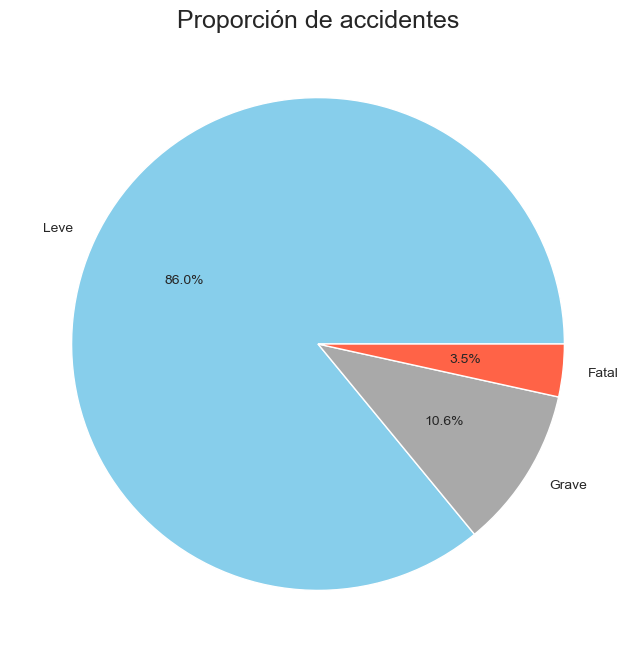

In [63]:
#Creamos un objeto con la proporción de accidentes leves, graves y fatales

prop_accidentes = accidentes['gravedad_acc'].value_counts(normalize=True)

#Lo graficamos

fig = plt.figure(figsize=(8,8))
plt.pie(prop_accidentes, labels=prop_accidentes.index, autopct='%.1f%%',colors=['skyblue', 'darkgrey','tomato'])
plt.title('Proporción de accidentes', fontsize=18)
plt.show()

### Determinar el día específico de la semana y la hora del día en que se producen la mayoría de los accidentes fatales.

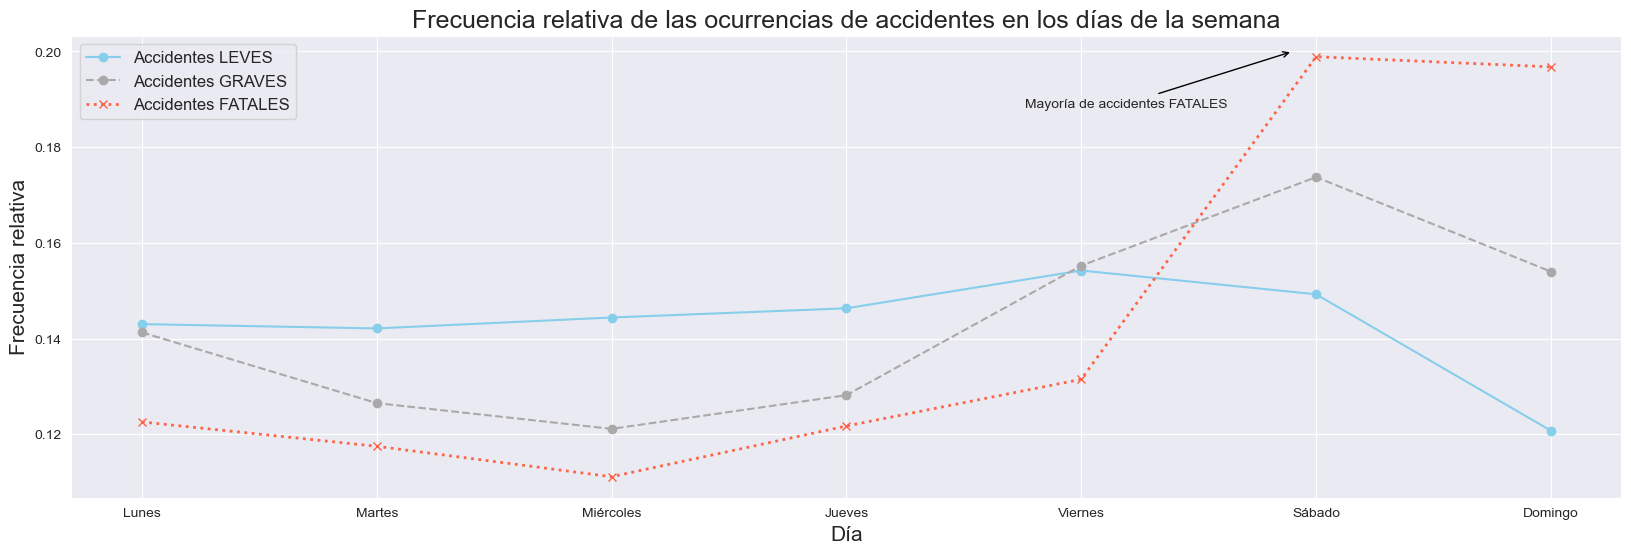

In [64]:
#Creamos las tablas de frecuencia relativa por cada día, para accidentes graves y graves.
freq_leves_rel = accidentes_leves['dia'].value_counts(normalize=True, sort=False)
freq_graves_rel = accidentes_graves['dia'].value_counts(normalize=True, sort=False)
freq_fatales_rel = accidentes_fatales['dia'].value_counts(normalize=True, sort=False)

#Graficamos

fig = plt.figure(figsize=(20,6))
freq_leves_rel.plot(marker='o', label='Accidentes LEVES', color=['skyblue'])
freq_graves_rel.plot(marker='o', linestyle='--', label='Accidentes GRAVES',color=['darkgrey'])
freq_fatales_rel.plot(marker='x', linestyle=':', linewidth=2, label='Accidentes FATALES',color=['tomato'])

plt.title('Frecuencia relativa de las ocurrencias de accidentes en los días de la semana', fontsize=18)
plt.xlabel('Día', fontsize= 15)
plt.ylabel('Frecuencia relativa', fontsize=15)
plt.annotate("Mayoría de accidentes FATALES", xy=(4.9, 0.20),  xycoords='data',
            xytext=(-120, -40), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->", color='black'))
plt.legend(fontsize=12)
plt.show()

#### Del gráfico anterior podemos extraer lo siguiente:


■ La mayoría de los accidentes **FATALES** se produjeron el día Sábado **(20%)**, seguidos por el Domingo **(19,3%)**.

■ La linea de accidentes **GRAVES** se mantiene por debajo de la de **LEVES** hasta el Sábado que asciende al **(17,3%)**, pero no supera 

■ Los accidentes **LEVES** mantienen una distribución pareja (entre el 14,2% y el 15,3%) a excepción del Domingo, que cae al 12% sobre el total de accidentes NO graves.


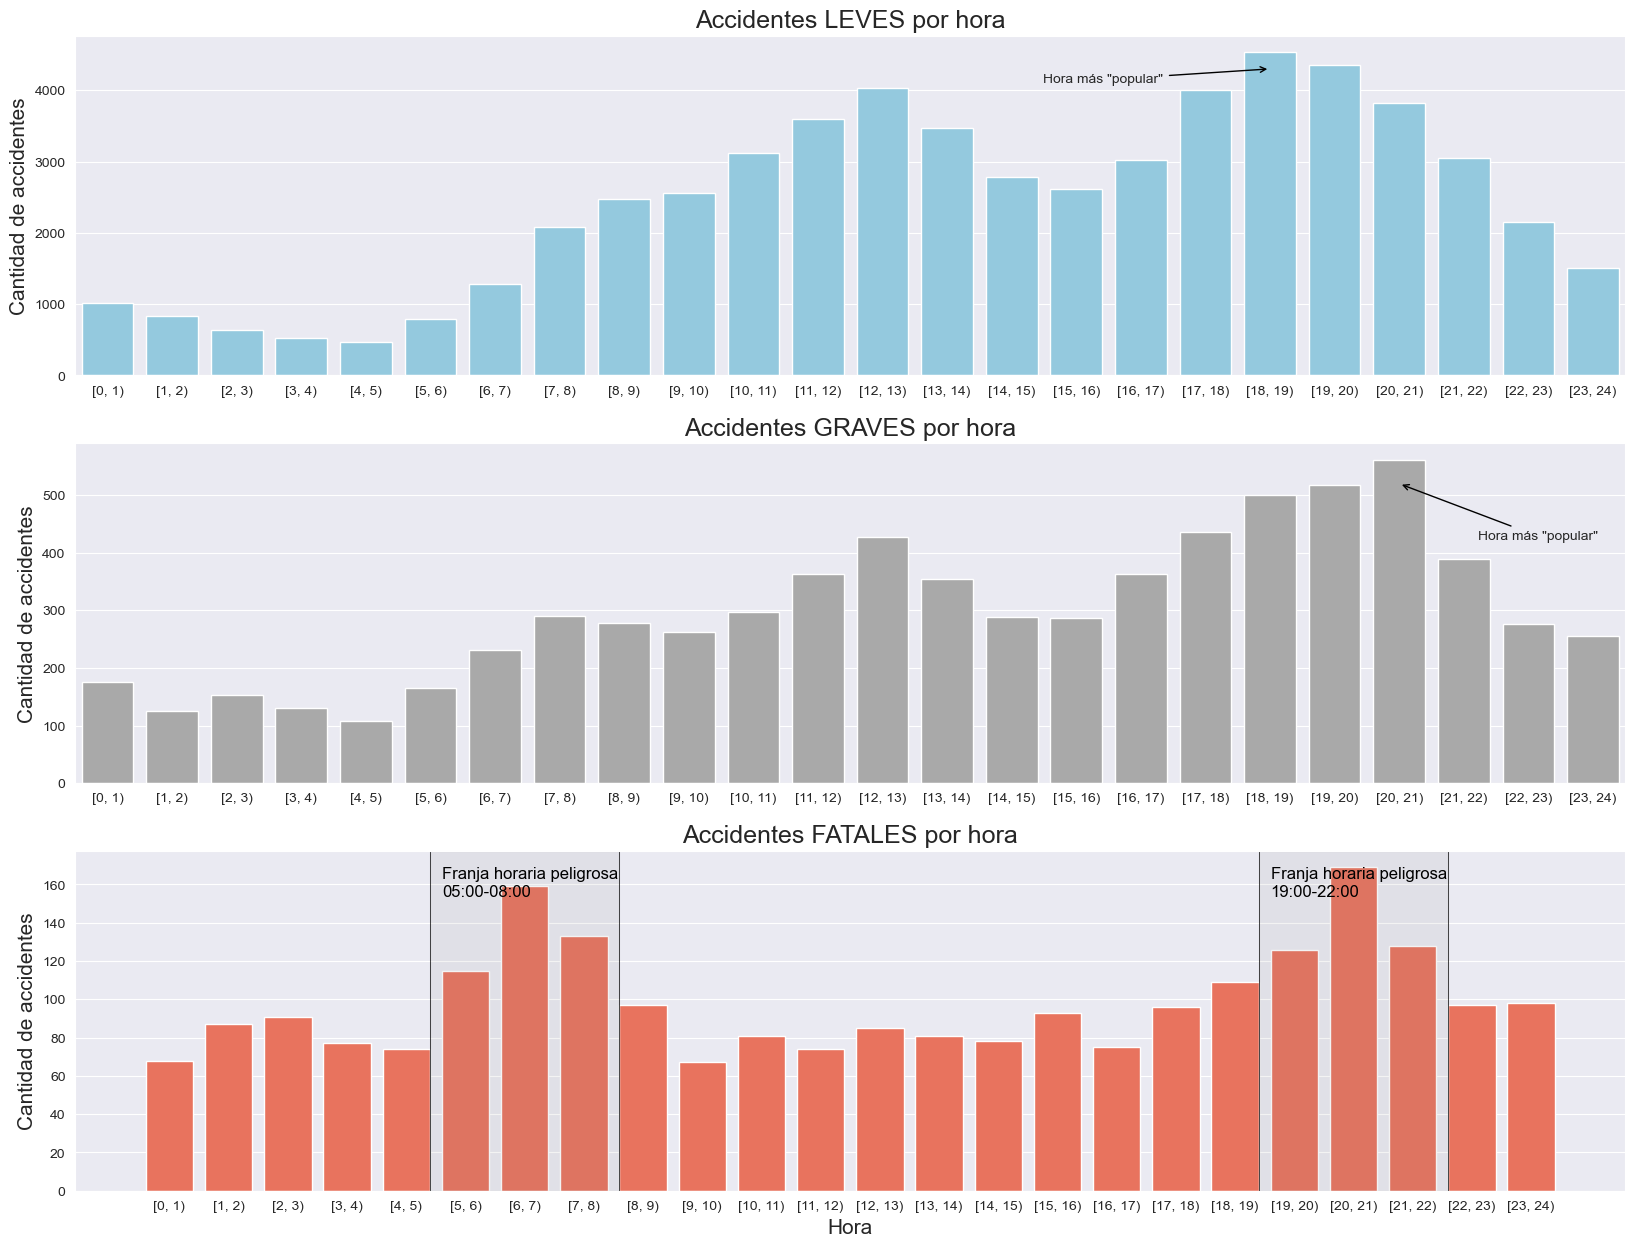

In [65]:
# Vamos a crear los intervalos de hora
bins = list(range(0, 25))

# Intervalos para acidentes leves
accidentes_leves['interv_hora'] = pd.cut(accidentes_leves['hora'], bins, right = False)

# Intervalos para accidentes graves
accidentes_graves['interv_hora'] = pd.cut(accidentes_graves['hora'], bins, right = False)

# Intervalos para accidentes fatales
accidentes_fatales['interv_hora'] = pd.cut(accidentes_fatales['hora'], bins, right = False)


#Graficamos

fig, ax =plt.subplots(3,1, figsize=(20, 15))
sns.countplot(accidentes_leves.interv_hora, ax=ax[0], color='skyblue')
sns.countplot(accidentes_graves.interv_hora, ax=ax[1], color='darkgrey')
sns.countplot(accidentes_fatales.interv_hora, ax=ax[2], color='tomato')



ax[0].set_title('Accidentes LEVES por hora',fontsize=18)
ax[0].set_ylabel('Cantidad de accidentes', fontsize=15)
ax[0].set_xlabel(' ', fontsize=15)
ax[0].annotate('Hora más "popular"', xy=(18, 4300),  xycoords='data',
            xytext=(-120, -10), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->", color='black'))



ax[1].set_title('Accidentes GRAVES por hora',fontsize=18)
ax[1].set_ylabel('Cantidad de accidentes', fontsize=15)
ax[1].set_xlabel(' ', fontsize=15)
ax[1].annotate('Hora más "popular"', xy=(20, 520),  xycoords='data',
            xytext=(100, -40), textcoords='offset points', ha='center',
            arrowprops=dict(arrowstyle="->", color='black'))


ax[2].set_title('Accidentes FATALES por hora',fontsize=18)
ax[2].set_ylabel('Cantidad de accidentes', fontsize=15)
ax[2].set_xlabel('Hora', fontsize=15)
ax[2].axvline(x=4.4, color='black', lw=.5)
ax[2].axvline(x=7.6, color='black', lw=.5)
ax[2].axvspan(4.4, 7.6, alpha=0.09, color='grey')
ax[2].text(s='Franja horaria peligrosa \n05:00-08:00', x=4.6, y=154, color = 'k',fontsize=12)
# ax[2].annotate('Hora crítica', xy=(20, 160),  xycoords='data',
#             xytext=(100, -40), textcoords='offset points', ha='center',
#             arrowprops=dict(arrowstyle="->", color='black'))
ax[2].axvline(x=18.4, color='black', lw=.5)
ax[2].axvline(x=21.6, color='black', lw=.5)
ax[2].axvspan(18.4, 21.6, alpha=0.09, color='grey')
ax[2].text(s='Franja horaria peligrosa \n19:00-22:00', x=18.6, y=154, color = 'k',fontsize=12)
# ax[2].annotate('Hora crítica', xy=(6, 155),  xycoords='data',
#             xytext=(-90, -40), textcoords='offset points', ha='center',
#             arrowprops=dict(arrowstyle="->", color='black'))

fig.show()

#### Del gráfico anterior podemos extraer lo siguiente:


■ La mayoría de los accidentes **LEVES** se produjeron en torno a las **(18HS)**.

■ La mayoría de los accidentes **GRAVES** se produjeron en torno a las **(20HS)**. seguido por las **(19HS)** Y **(18HS)** respectivamente.

■ La mayoría de los accidentes **FATALES** se produjeron en torno a las **(20HS)**, seguidos por las **(6HS)** y **(7HS)**,  respectivamente.

A partir de ahora vamos a enfocar este análisis en los accidentes GRAVES y FATALES

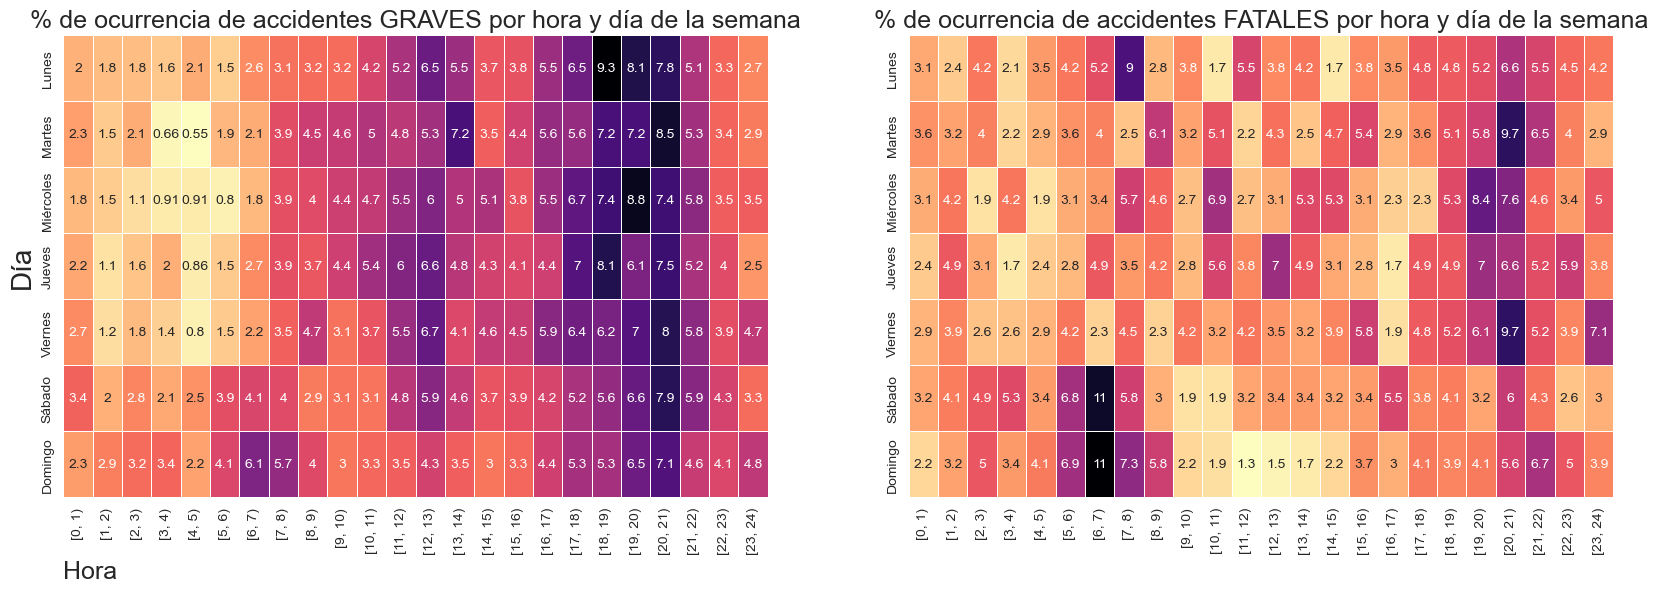

In [66]:
#Vamos a cruzar datos entre horas y días para encontrar patrones

# Creamos la tabla cruzada para accidentes graves no fatales
datos_cruzados_g = pd.crosstab(accidentes_graves.dia, accidentes_graves.interv_hora,normalize='index')*100

# Creamos la tabla cruzada para accidentes fatales
datos_cruzados_f = pd.crosstab(accidentes_fatales.dia, accidentes_fatales.interv_hora,normalize='index')*100

#Graficamos
fig, ax =plt.subplots(1,2, figsize=(20, 6))
sns.heatmap(datos_cruzados_g, cmap = "magma_r", annot = True,linewidth=.5, ax = ax[0], cbar=False)
sns.heatmap(datos_cruzados_f, cmap = "magma_r", annot = True,linewidth=.5, ax = ax[1], cbar=False)
ax[0].set_xlabel("Hora", fontsize=18, loc='left')
ax[0].set_ylabel("Día", fontsize=20)
ax[0].set_title("% de ocurrencia de accidentes GRAVES por hora y día de la semana", fontsize=18)
ax[1].set_xlabel("")
ax[1].set_ylabel("")
ax[1].set_title("% de ocurrencia de accidentes FATALES por hora y día de la semana", fontsize=18)
plt.show()

#### Del gráfico anterior podemos extraer los siguientes patrones:


■ De Lunes a Viernes en horas de la madrugada (00HS.a 6HS.) suele ser el período donde menos accidentes ocurren, tanto como para accidentes GRAVES, como para FATALES.

■ En el caso de accidentes **GRAVES**, la cantidad tiende a aumentar en torno a las 7HS. (esto se debe al traslado hacia el trabajo), alcanzando sus máximos entre las 17HS. y las 21HS.

Observamos patrones diferentes si hablamos del  Sábado y el Domingo, ya que los accidentes tienen aumento en la madrugada más notablemente entre las 5HS.Y LAS 9HS.

■ En el caso de accidentes **FATALES** la diferencia es aún más marcada si hablamos del findesemana, con aumentos desde las 20HS alcanzando sus máximos en torno a las 6HS. (esto se debe al traslado de las personas a eventos sociales, y los máximos al regreso de las mismos, donde entran en juego otras variables que no abordaremos en este análisis como el de consumo de alcohol y drogas).

### Determinar, cuál es la vía en la que ocurren más accidentes fatales.

In [67]:
#Generamos una tabla de datos cruzados entre gravedad de accidentes y tipo de vía
desc_tipo =pd.crosstab(accidentes.gravedad_acc,accidentes.desc_tipo_via).apply(lambda x: x*100/x.sum(), axis=1)

#Stackeamos la tabla y reseteamos el índice
desc_tipo =desc_tipo.stack().reset_index().rename(columns={0:'Porcentaje'})
desc_tipo.head(3)

,gravedad_acc,desc_tipo_via,Porcentaje
0,Fatal,Autopista,8.481764
1,Fatal,Autovía,1.060221
2,Fatal,Avenida,10.687023


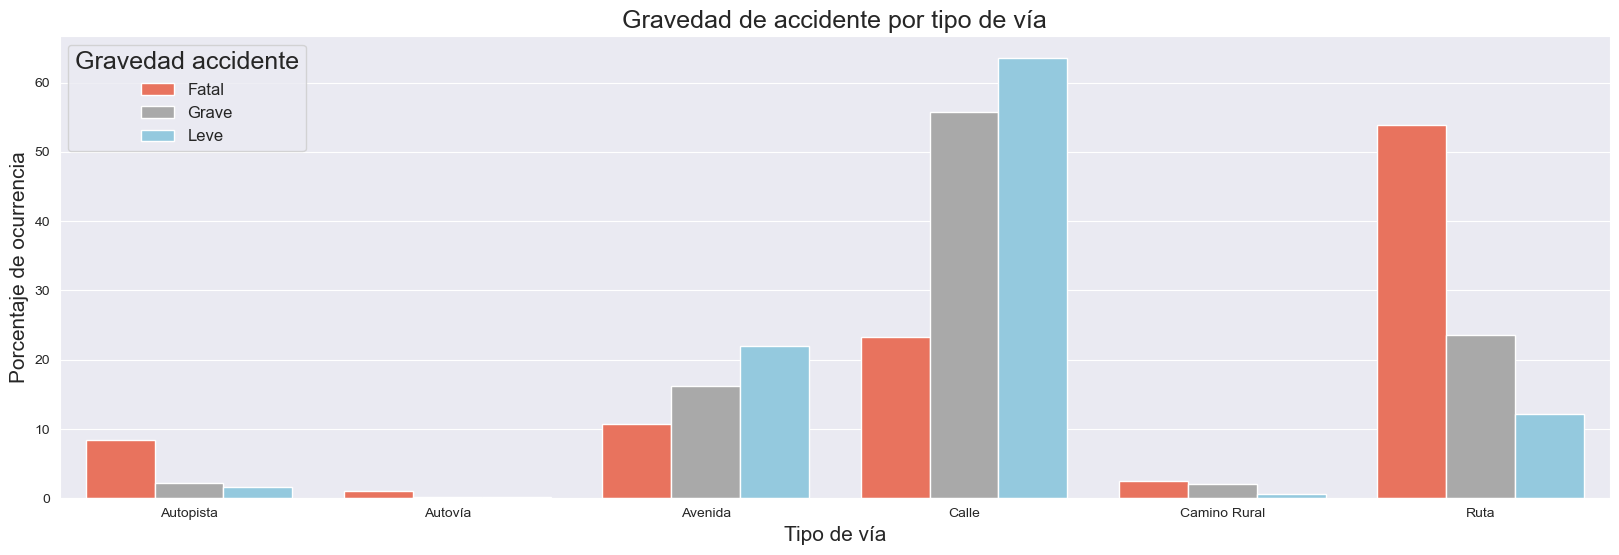

In [68]:
#Graficamos
fig = plt.figure(figsize=(20,6))
desc = sns.barplot(x="desc_tipo_via", y="Porcentaje", hue="gravedad_acc", data=desc_tipo, palette=['tomato', 'darkgrey','skyblue'])

plt.ylabel('Porcentaje de ocurrencia', fontsize=15)
plt.xlabel('Tipo de vía', fontsize=15)
plt.title('Gravedad de accidente por tipo de vía', fontsize=18)

plt.legend(title='Gravedad accidente',title_fontsize=18, fontsize=12, loc='upper left')
plt.show()

#### Del gráfico anterior podemos extraer lo siguiente:


■ Más del **54%** de los accidentes **FATALES** se dieron en **RUTAS**, seguido por calles (22%), avenidas(12%), autopistas(9%) y los demás (3%) respectivamente.

■ En el caso de accidentes **GRAVES**, ocurrieron en torno al **72%** entre **CALLES y AVENIDAS**, seguido por rutas (24%) y los demás (4%) respectivamente.

■ En el caso de accidentes **LEVES**, se dieron en su mayoría en calles y avenidas (86%).

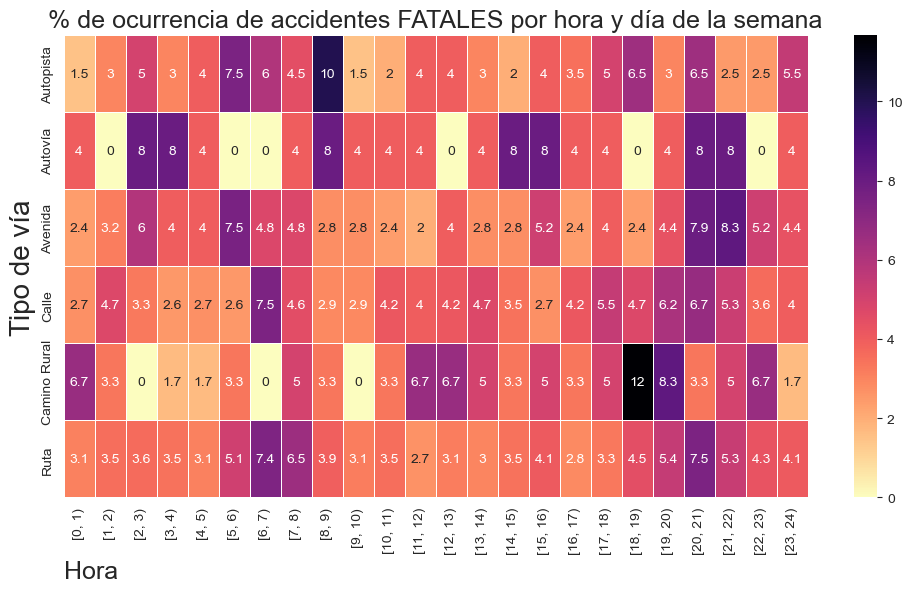

In [69]:
#Vamos a cruzar datos entre horas y tipo de vía para encontrar patrones

# Creamos la tabla cruzada para accidentes fatales
datos_cruzados_fz = pd.crosstab(accidentes_fatales.desc_tipo_via, accidentes_fatales.interv_hora,normalize='index')*100

#Graficamos
fig= plt.figure(figsize=(12, 6))
sns.heatmap(datos_cruzados_fz, cmap = "magma_r", annot = True, linewidth=.5, cbar=True)
plt.xlabel("Hora", fontsize=18, loc='left')
plt.ylabel("Tipo de vía", fontsize=20)
plt.title("% de ocurrencia de accidentes FATALES por hora y día de la semana", fontsize=18)
plt.show()

In [70]:
#Generamos una tabla de datos cruzados entre gravedad de accidentes y la zona
desc_zona =np.round(pd.crosstab(accidentes.gravedad_acc,accidentes.desc_zona).apply(lambda x: x*100/x.sum(), axis=1),2)
# #Stackeamos la tabla y reseteamos el índice
desc_zona = desc_zona.stack().reset_index().rename(columns={0:'Porcentaje'})
desc_zona

,gravedad_acc,desc_zona,Porcentaje
0,Fatal,Rural,43.38
1,Fatal,Urbana,56.62
2,Grave,Rural,13.02
3,Grave,Urbana,86.98
4,Leve,Rural,5.26
5,Leve,Urbana,94.74


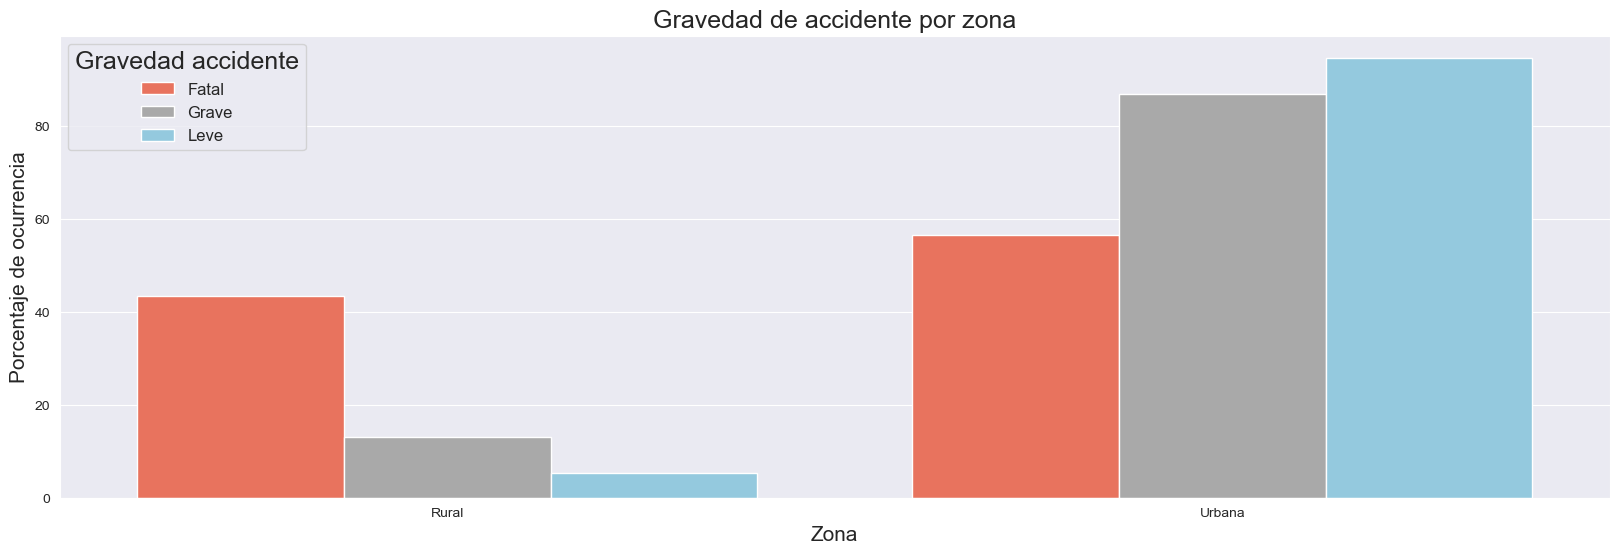

In [71]:
#Graficamos
fig = plt.figure(figsize=(20,6))
desc = sns.barplot(x="desc_zona", y="Porcentaje", hue="gravedad_acc", data=desc_zona, palette=['tomato', 'darkgrey','skyblue'])

plt.ylabel('Porcentaje de ocurrencia', fontsize=15)
plt.xlabel('Zona', fontsize=15)
plt.title('Gravedad de accidente por zona', fontsize=18)

plt.legend(title='Gravedad accidente',title_fontsize=18, fontsize=12, loc='upper left')
plt.show()

#### Del gráfico anterior podemos extraer lo siguiente:


■ Si bien la ocurrencia de accidentes **FATALES** es mayor en zonas urbanas, éste no es el predominante, sin embargo en zonas rurales notamos una marcada diferencia en zonas rurales respecto a las otras categorías.

In [72]:
#Generamos una tabla de datos cruzados entre gravedad de accidentes y la zona
desc_clima =np.round(pd.crosstab(accidentes.gravedad_acc,accidentes.desc_estado_clima).apply(lambda x: x*100/x.sum(), axis=1),2)
# #Stackeamos la tabla y reseteamos el índice
desc_clima = desc_clima.stack().reset_index().rename(columns={0:'Porcentaje'})
desc_clima.head()

,gravedad_acc,desc_estado_clima,Porcentaje
0,Fatal,Buen Tiempo,87.19
1,Fatal,Escarcha,0.13
2,Fatal,Granizo,0.04
3,Fatal,Lluvia,7.08
4,Fatal,Niebla,2.50


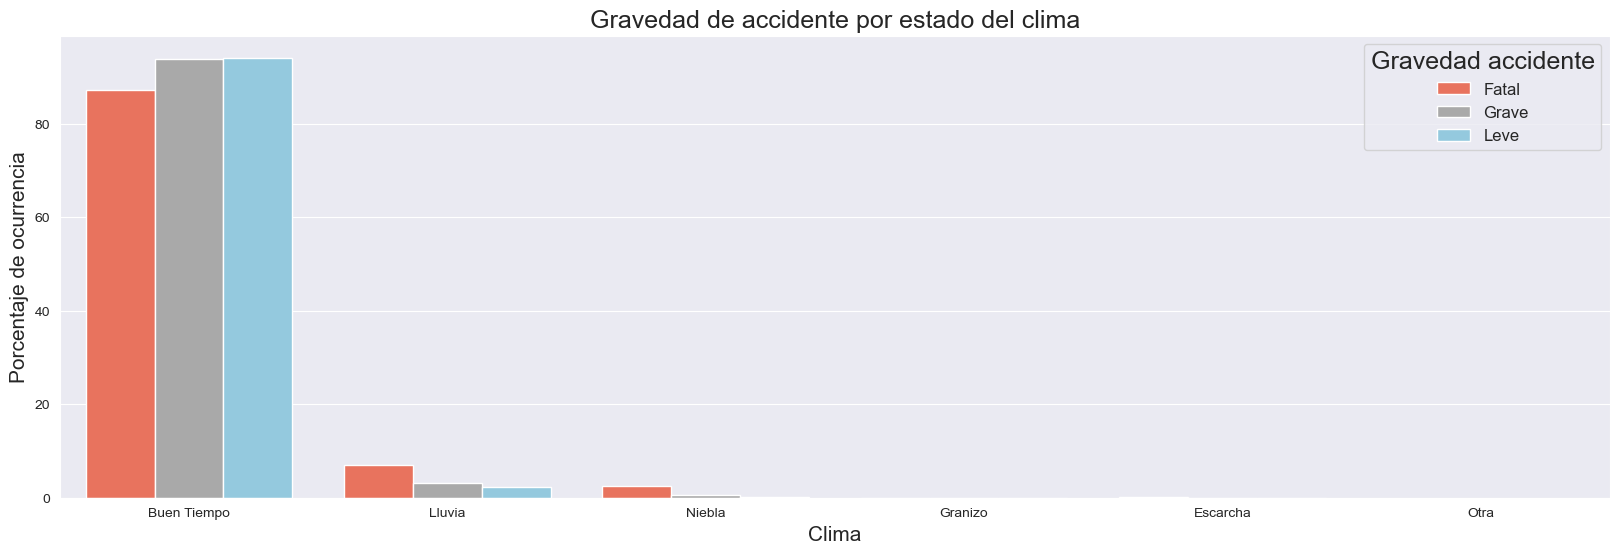

In [73]:
#Graficamos
fig = plt.figure(figsize=(20,6))
desc = sns.barplot(x="desc_estado_clima", y="Porcentaje", hue="gravedad_acc", data=desc_clima,order=['Buen Tiempo','Lluvia','Niebla','Granizo','Escarcha','Otra'], palette=['tomato', 'darkgrey','skyblue'])

plt.ylabel('Porcentaje de ocurrencia', fontsize=15)
plt.xlabel('Clima', fontsize=15)
plt.title('Gravedad de accidente por estado del clima', fontsize=18)

plt.legend(title='Gravedad accidente',title_fontsize=18, fontsize=12, loc='upper right')
plt.show()

#### De los gráficos anteriores podemos extraer lo siguiente:


■ Más del **80%** del total de los accidentes se dieron con **BUEN TIEMPO**.

■ En el de los climas lluviosos y con niebla los accidentes predominantes son los **FATALES**.



In [111]:
accidentes_fatales['desc_lugar_via'].value_counts()

Recta                1357
Intersección          659
Curva                 170
Cruce                  44
Puente                 34
Paso a Nivel FFCC      25
Rotonda                24
Otro                   16
Distribuidor           12
Pendiente               2
Name: desc_lugar_via, dtype: int64

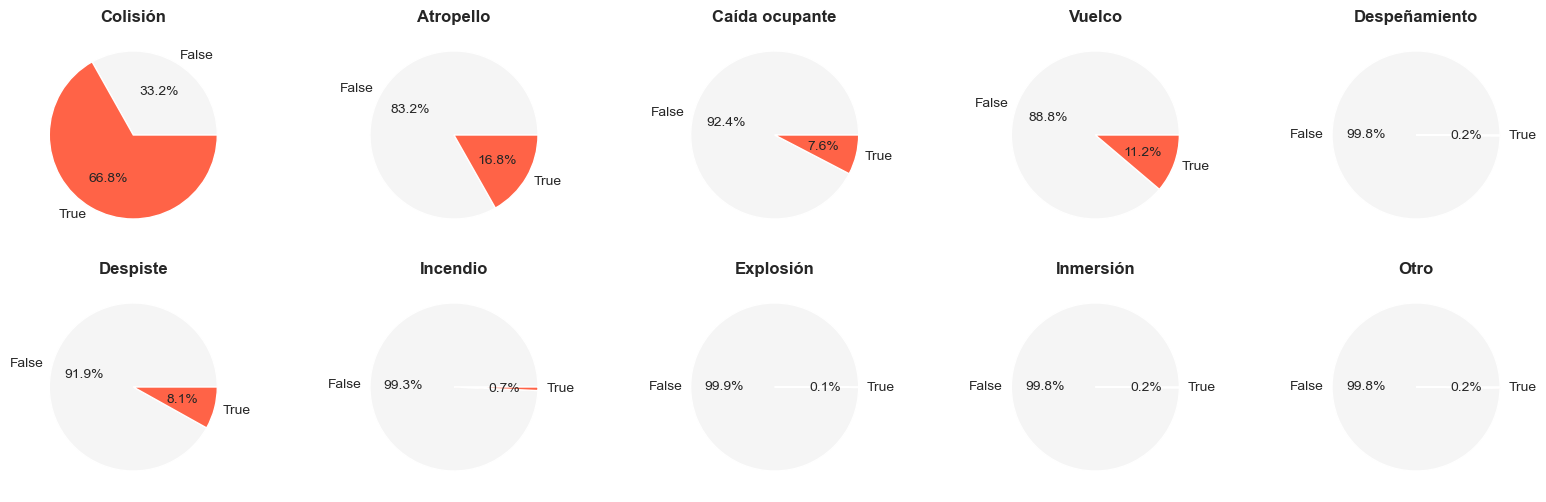

In [74]:
# SConfiguración de los subgráficos
fig = plt.figure(figsize=(20,6)) 
fig_dims = (2, 5)


# Graficamos los accidentes dependiendo del tipo de hecho
plt.subplot2grid(fig_dims, (0, 0))
accidentes_fatales['Colisión'].value_counts(normalize=True).sort_index().plot.pie(autopct='%1.1f%%', colors=['whitesmoke','tomato'])
plt.ylabel("")
plt.title('Colisión',fontweight ="bold")

plt.subplot2grid(fig_dims, (0, 1))
accidentes_fatales['Atropello'].value_counts(normalize=True).sort_index().plot.pie(autopct='%1.1f%%', colors=['whitesmoke','tomato'])
plt.ylabel("")
plt.title('Atropello',fontweight ="bold")

plt.subplot2grid(fig_dims, (0, 2))
accidentes_fatales['Caída ocupante'].value_counts(normalize=True).sort_index().plot.pie(autopct='%1.1f%%', colors=['whitesmoke','tomato'])
plt.ylabel("")
plt.title('Caída ocupante',fontweight ="bold")

plt.subplot2grid(fig_dims, (0, 3))
accidentes_fatales['Vuelco'].value_counts(normalize=True).sort_index().plot.pie(autopct='%1.1f%%', colors=['whitesmoke','tomato'])
plt.ylabel("")
plt.title('Vuelco',fontweight ="bold")

plt.subplot2grid(fig_dims, (0, 4))
accidentes_fatales['Despeñamiento'].value_counts(normalize=True).sort_index().plot.pie(autopct='%1.1f%%', colors=['whitesmoke','tomato'])
plt.ylabel("")
plt.title('Despeñamiento',fontweight ="bold")

plt.subplot2grid(fig_dims, (1, 0))
accidentes_fatales['Despiste'].value_counts(normalize=True).sort_index().plot.pie(autopct='%1.1f%%', colors=['whitesmoke','tomato'])
plt.ylabel("")
plt.title('Despiste',fontweight ="bold")

plt.subplot2grid(fig_dims, (1, 1))
accidentes_fatales['Incendio'].value_counts(normalize=True).plot.pie(autopct='%1.1f%%', colors=['whitesmoke','tomato'])
plt.ylabel("")
plt.title('Incendio',fontweight ="bold")

plt.subplot2grid(fig_dims, (1, 2))
accidentes_fatales['Explosión'].value_counts(normalize=True).sort_index().plot.pie(autopct='%1.1f%%', colors=['whitesmoke','tomato'])
plt.ylabel("")
plt.title('Explosión',fontweight ="bold")


plt.subplot2grid(fig_dims, (1, 3))
accidentes_fatales['Inmersión'].value_counts(normalize=True).sort_index().plot.pie(autopct='%1.1f%%', colors=['whitesmoke','tomato'])
plt.ylabel("")
plt.title('Inmersión',fontweight ="bold")


plt.subplot2grid(fig_dims, (1, 4))
accidentes_fatales['Otro'].value_counts(normalize=True).sort_index().plot.pie(autopct='%1.1f%%', colors=['whitesmoke','tomato'])
plt.ylabel("")
plt.title('Otro',fontweight ="bold")

plt.show()

### Sobre los participantes

In [75]:
#Calculamos el promedio de la cantidad de participantes según la gravedad del accidente

print('El promedio de participantes en accidentes leves es de: '+'\033[1m'+str(np.round(accidentes_leves['cant_participantes'].mean(),2))+'\033[0m')

print('El promedio de participantes en accidentes graves es de: '+'\033[1m'+str(np.round(accidentes_graves['cant_participantes'].mean(),2))+'\033[0m')

print('El promedio de participantes en accidentes fatales es de: '+'\033[1m'+str(np.round(accidentes_fatales['cant_participantes'].mean(),2))+'\033[0m')

El promedio de participantes en accidentes leves es de: 1.92
El promedio de participantes en accidentes graves es de: 1.86
El promedio de participantes en accidentes fatales es de: 1.83


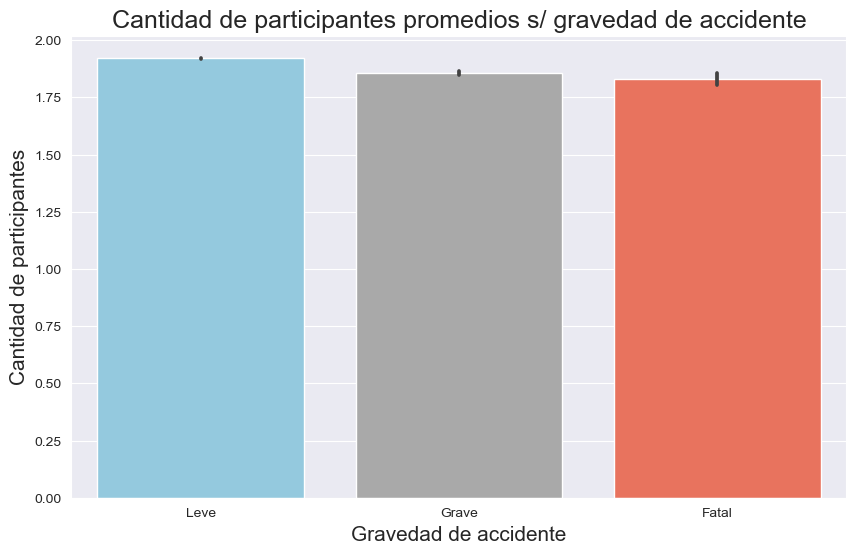

In [76]:
fig = plt.figure(figsize=(10,6))
sns.barplot(data=accidentes, x='gravedad_acc', y='cant_participantes',
            ci=95, order=['Leve','Grave','Fatal'], palette=['skyblue','darkgrey','tomato'])
plt.title('Cantidad de participantes promedios s/ gravedad de accidente', fontsize=18)
plt.ylabel('Cantidad de participantes',fontsize=15)
plt.xlabel('Gravedad de accidente', fontsize=15)
plt.show()

In [77]:
# Veamos el intérvalo de confianza del promedio de la cantidad de participantes en los accidentes fatales

f_data = accidentes_fatales['cant_participantes']
  
# Creamos el intervalo de confianza del 95%
st.t.interval(alpha=0.95, df=len(f_data)-1,
              loc=np.mean(f_data),
              scale=st.sem(f_data))

(1.8025186594409461, 1.856514419439461)

#### Del gráfico anterior podemos extraer lo siguiente:


■ La cantidad promedio de participantes en accidentes **FATALES** es de **1.83** siendo esta la menor  con un intervalo de confianza de (1.80 , 1.85)... podemos decir que en un muestreo repetido, vamos a producir intérvalos que incluyan la media en un 95% de los casos. 

■ La cantidad promedio de participantes en accidentes **GRAVES** es de **1.86**.

■ La cantidad promedio de participantes en accidentes **LEVES** es de **1.92**.


En términos generales podemos interpretar esto como que la mayoría de los accidentes fatales ocurren con menos vehículos participantes que los demás.  

In [78]:
#Definimos una función para graficar el promedio de una columna por hora

def plotPromh(df,col,ax, label, color, marc, linea):
    """Función para graficar el promedio por hora de una columna"""
    grouped = df.groupby(['interv_hora'])[col].agg(['size','mean'])
    
    sns.lineplot(data=grouped, x=grouped.index.astype(str), y='mean',ax=ax, label=label, linewidth=2, color=color, marker=marc, linestyle=linea),
    
    ax.set_xlim(xmin=1, xmax=11)
    ax.set_xticks([i for i in range(0,24)])
    ax.tick_params(which='both', labelsize=13)
    ax.set_xlabel('Hora', fontsize=15)
    ax.set_ylabel('Promedio', fontsize=15)
    plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


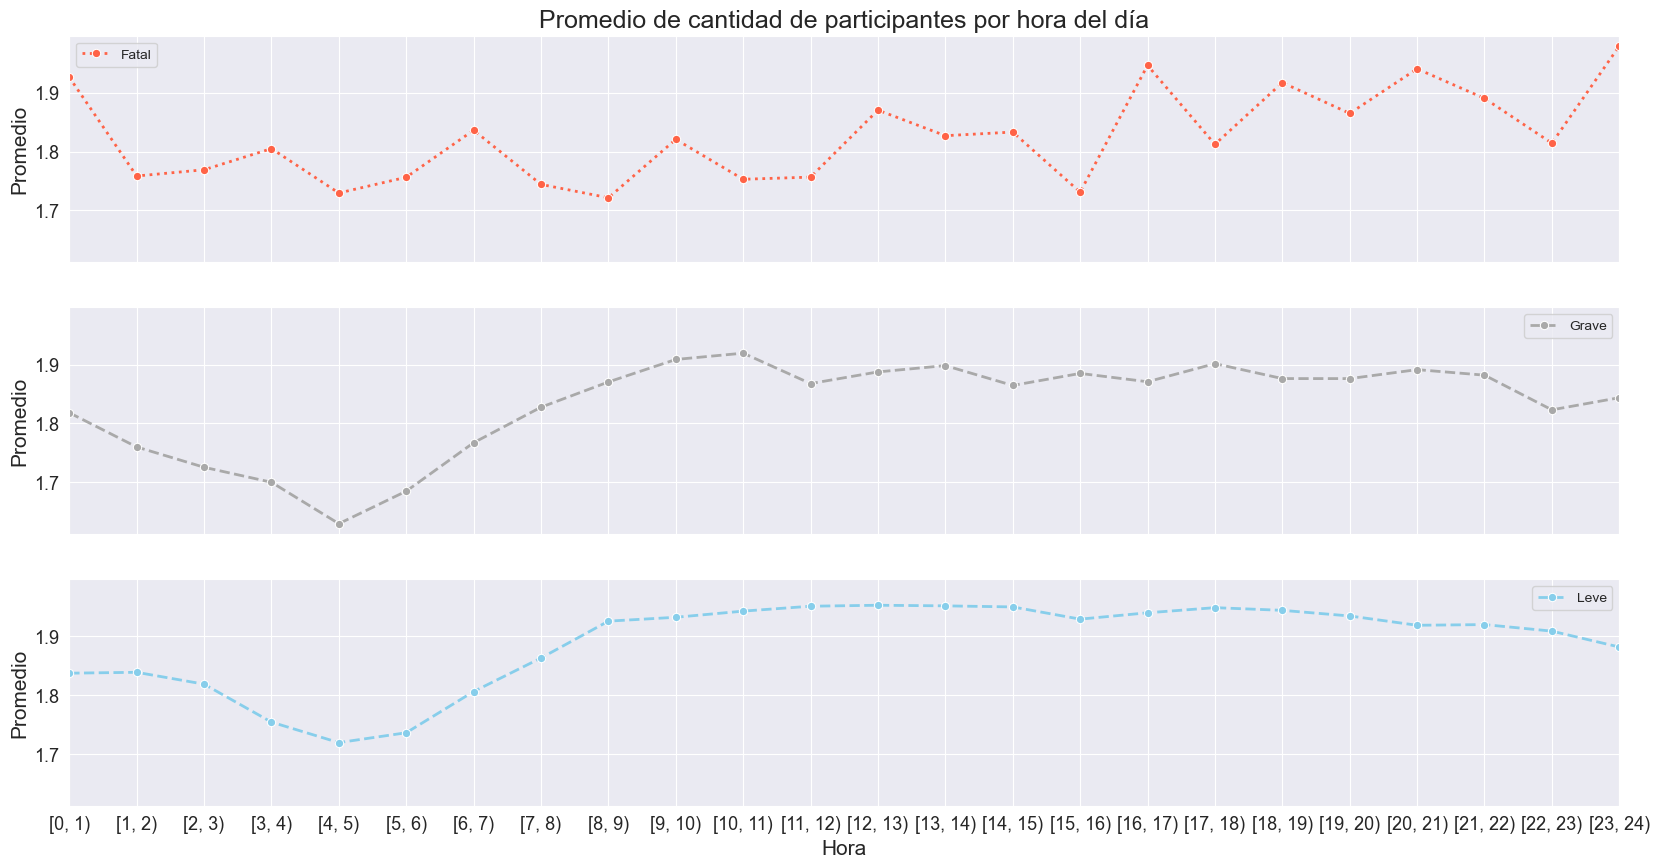

In [79]:
# Graficamos el promedio de la cantidad de participantes según el tipo de accidente.
fig, ax = plt.subplots(3, 1, figsize=(20,10), sharey=True,sharex=True)

plotPromh(accidentes_fatales, 'cant_participantes',ax[0], 'Fatal', 'tomato', 'o',':')
plotPromh(accidentes_graves, 'cant_participantes',ax[1],'Grave', 'darkgrey', 'o','--')
plotPromh(accidentes_leves, 'cant_participantes',ax[2],'Leve','skyblue','o','--')

ax[0].set_title('Promedio de cantidad de participantes por hora del día', fontsize=18)
plt.show()

In [80]:
#Definimos una función para graficar el promedio de una columna por día
def plotPromd(df,col,ax, label, color, marc, linea):
    """Función para graficar el promedio por hora de una columna"""
    grouped = df.groupby(['dia'])[col].agg(['size','mean'])
    
    sns.lineplot(data=grouped, x=grouped.index.astype(str), y='mean',ax=ax, label=label, linewidth=2, color=color, marker=marc, linestyle=linea),
    
    ax.set_xlim(xmin=0, xmax=6)
    ax.set_xticks([i for i in range(0,7)])
    ax.tick_params(which='both', labelsize=13)
    ax.set_xlabel('Día', fontsize=15)
    ax.set_ylabel('Promedio', fontsize=15)
    plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


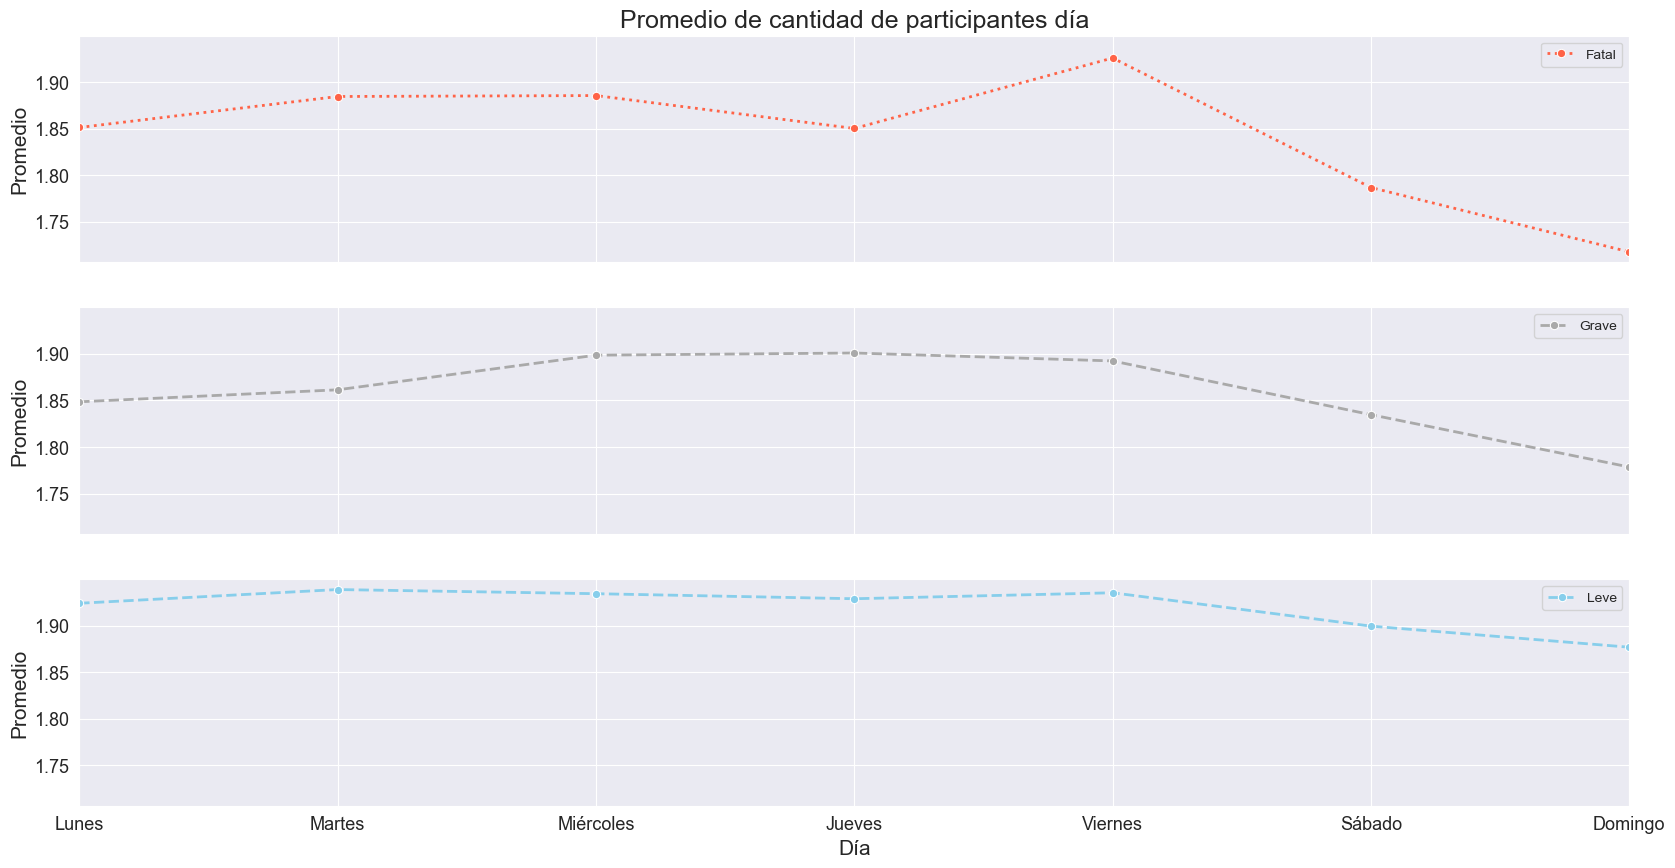

In [81]:
fig, ax = plt.subplots(3, 1, figsize=(20,10), sharey=True,sharex=True)

plotPromd(accidentes_fatales, 'cant_participantes',ax[0], 'Fatal', 'tomato', 'o',':')
plotPromd(accidentes_graves, 'cant_participantes',ax[1],'Grave', 'darkgrey', 'o','--')
plotPromd(accidentes_leves, 'cant_participantes',ax[2],'Leve','skyblue','o','--')

ax[0].set_title('Promedio de cantidad de participantes día', fontsize=18)
plt.show()

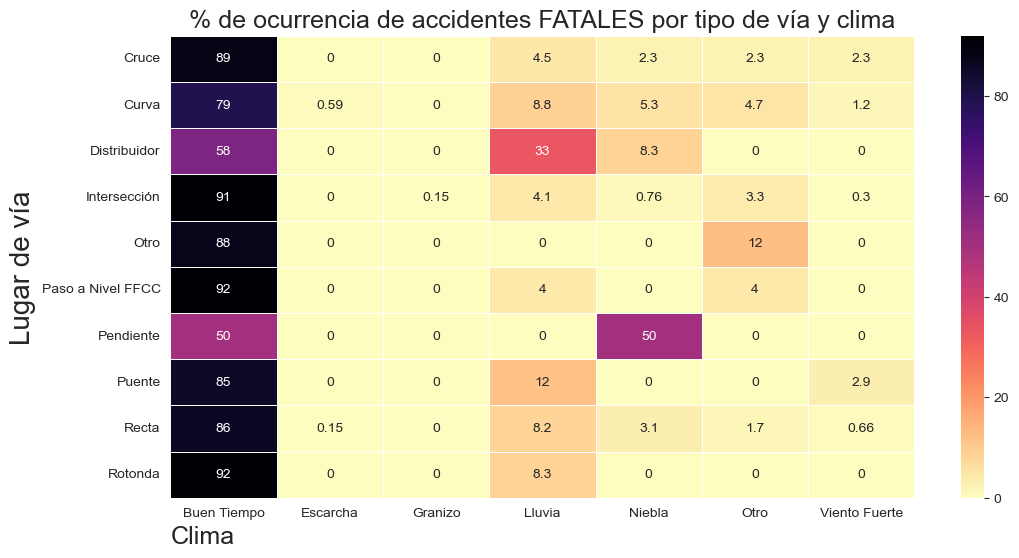

In [131]:
#Vamos a cruzar datos entre lugar de vía y clima para encontrar patrones

# Creamos la tabla cruzada para accidentes fatales
datos_cruzados_vc = pd.crosstab(accidentes_fatales.desc_lugar_via, accidentes_fatales.desc_estado_clima,normalize='index')*100

#Graficamos
fig= plt.figure(figsize=(12, 6))
sns.heatmap(datos_cruzados_vc, cmap = "magma_r", annot = True, linewidth=.5, cbar=True)
plt.xlabel("Clima", fontsize=18, loc='left')
plt.ylabel("Lugar de vía", fontsize=20)
plt.title("% de ocurrencia de accidentes FATALES por tipo de vía y clima", fontsize=18)
plt.show()

# Geopandas & Geoplot

In [82]:
#Verificamos la cantidad de nulos en nuestro set de datos creado en la fase de limpieza
geodata.isna().sum()

posicion_XY           72162
desc_loc                  0
desc_tipo_via             0
ilesos                    0
heridos_leves             0
heridos_graves            0
heridos_gravisimos        0
fallecidos                0
dtype: int64

Parece que hay 72162 accidentes sin una posición

In [83]:
geodata.dropna(inplace=True) #Eliminamos los datos nulos

In [84]:
#Vamos a separar la columna posición _XY en dos columnas de latitud y longitud

# Creamos listas vacías para almacenar los resultados del bucle
lat = []
lon = []

for row in geodata['posicion_XY']:
    
    try:

        lat.append(row.split(',')[0])

        lon.append(row.split(',')[1])
    except:
        # Exceptuando errores
        lat.append(np.NaN)
        # Agregando errores
        lon.append(np.NaN)

# Creamos las nuevas columnas y los datos que les pasamos son los de las listas creadas
geodata['latitude'] = lat
geodata['longitude'] = lon

#Transformamos nuestro data frame en un geo dta frame
geodata = geopandas.GeoDataFrame(
    geodata, geometry=geopandas.points_from_xy(geodata.longitude, geodata.latitude))

#Eliminamos las columnas que ya no vamos a necesitar'
geodata.drop(columns=['posicion_XY','latitude','longitude'], inplace=True)

#Creamos columna "gravedad_acc" con 3 categorías (Leve, Grave, Fatal) basándonos  en el grado de las lesiones de los participantes.
geodata['gravedad_acc'] = 'Leve'
geodata.loc[(geodata['heridos_graves'] >= 1) | (geodata['heridos_gravisimos'] >= 1), 'gravedad_acc'] = 'Grave'
geodata.loc[(geodata['fallecidos']>=1), 'gravedad_acc'] = 'Fatal'

#Subseteamos en 3 diferentes geodatasets para cada tipo de accidente
geo_leves = geodata[geodata['gravedad_acc'] == 'Leve']
geo_graves = geodata[geodata['gravedad_acc'] == 'Grave']
geo_fatales = geodata[geodata['gravedad_acc'] == 'Fatal']

In [85]:
#Obtenemos las URL de la API
url_sf = 'https://apis.datos.gob.ar/georef/api/departamentos?provincia=sf&formato=shp&max=1000'
sf = geopandas.read_file(url_sf)

In [86]:
#Dejaremos solos los accidentes fatales ocurridos en rutas y autopistas, ya que un análisis de grandes cascos urbanos amerita otro tipo de mapa
geo_fatalesrya = geo_fatales[geo_fatales['desc_tipo_via'].isin(['Ruta','Autopista'])]

#Leemos los datasets de rutas provinciales, nacionales y autopistas
r_prov = geopandas.read_file('rutas-provinciales.geojson')
r_prov = r_prov[r_prov['CLASE'] == 'Pavimentado'] #Solo pavimentadas
r_nac= geopandas.read_file('rutas-nacionales.geojson')
aut= geopandas.read_file('autopistas.geojson')

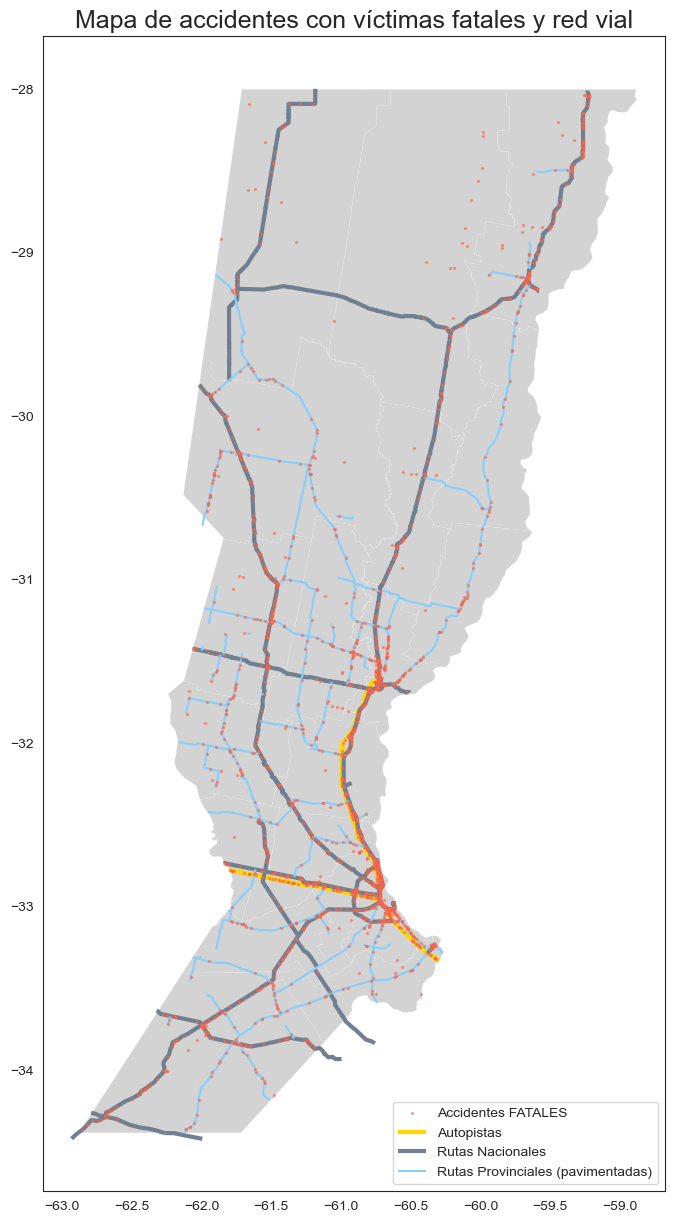

In [87]:
sns.set_style('white')
ax = sf.plot(color='lightgray',edgecolor='white',linewidth=.1, linestyle ='--',figsize=(15,15))
geo_fatalesrya.plot(ax=ax,marker='o',markersize=2, color='tomato', alpha=.5, label='Accidentes FATALES',zorder=5)


aut.plot(ax=ax,color='gold',linewidth=3, label='Autopistas')
r_nac.plot(ax=ax, color='slategray', linewidth=3, label='Rutas Nacionales', aspect='equal')
r_prov.plot(ax=ax,color='lightskyblue',linewidth=1.5,label='Rutas Provinciales (pavimentadas)')


plt.title('Mapa de accidentes con víctimas fatales y red vial', fontsize=18)
plt.legend()
plt.show()

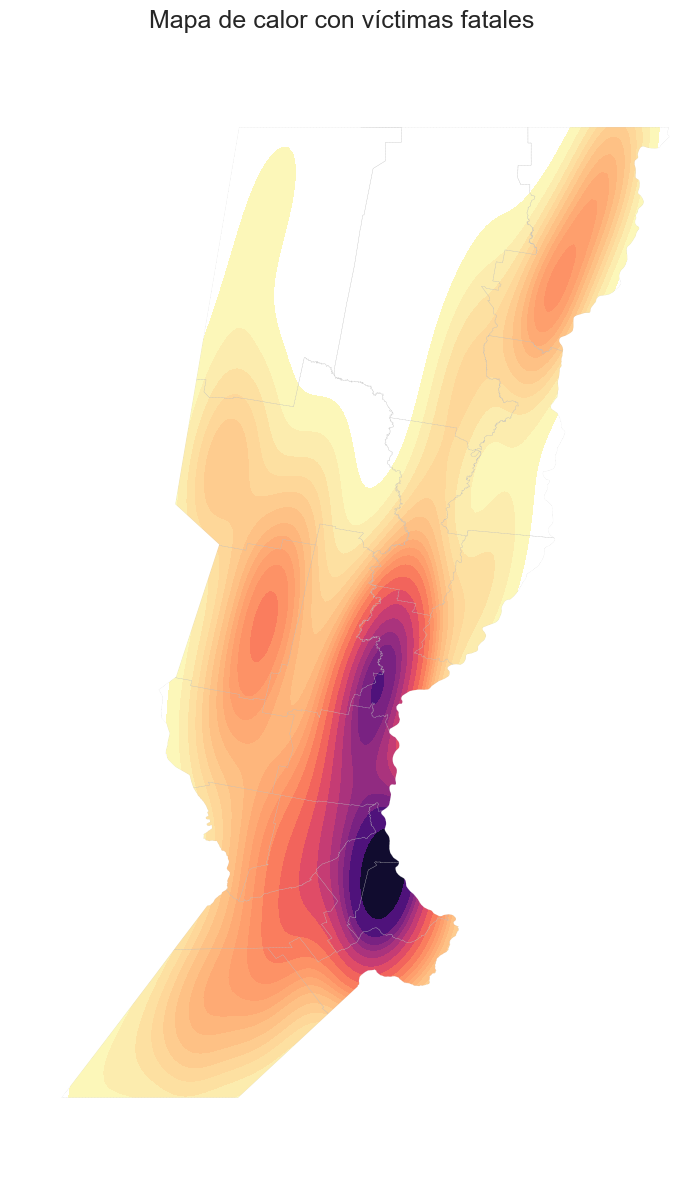

In [88]:
#Vamos a graficar un mapa de calor para visualizar de una mejor manera las zonas donde hay mayor ocurrencia de accidentes fatales

ax1 = gplt.polyplot(sf, projection=gcrs.PlateCarree(),zorder=1,linewidth=.2, linestyle ='--', edgecolor='silver',figsize=(10, 15))
gplt.kdeplot(geo_fatalesrya,n_levels=20, cmap='magma_r', shade=True, ax=ax1, clip=sf,zorder=0,figsize=(15, 15))
plt.title('Mapa de calor con víctimas fatales', fontsize=18)
plt.show()


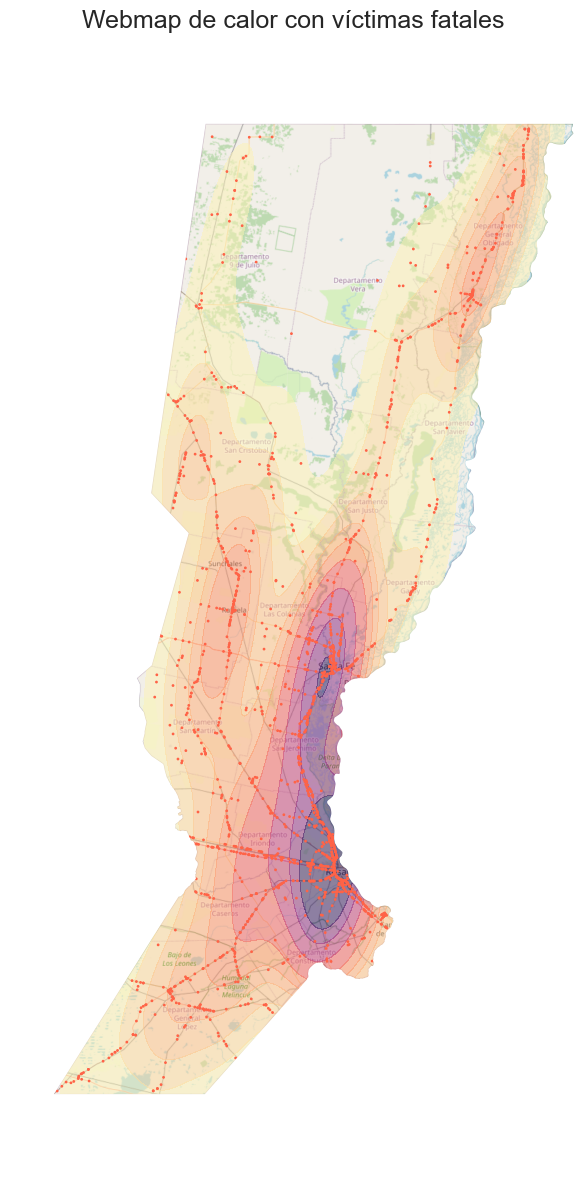

In [89]:
#Vamos a combinar heatmap y points con un webmap para identificar las zonas de mayor ocurrencia de accidentes fatales

ax1 = gplt.webmap(sf, projection=gcrs.WebMercator(),figsize=(15, 15))
gplt.kdeplot(geo_fatalesrya, ax=ax1,n_levels=10, clip=sf,cmap='magma_r',shade_lowest=False, shade=True, alpha=.5)
gplt.pointplot(geo_fatalesrya, s=1, color='tomato', ax=ax1)
plt.title('Webmap de calor con víctimas fatales', fontsize=18)
plt.show()